# <font color="darkorange"> Sales Prediction Project for Rossmann Drugstore Chain

- <font color="blue">**Data Scientist in charge**: Isabela Barbosa
- <font color="blue">**Last updated**: April 24th, 2023.    
- <font color="blue">**Status**: <ins>*V01 - Completed*</ins>

# <font color='darkblue'> 0.0. IMPORTING LIBRARIES, LOADING DATA AND DEFINING HELPER FUNCTIONS

In [1]:
import inflection
import math
import datetime
import warnings
import random
import pickle
import json
import requests
import pandas     as pd
import numpy      as np
import seaborn    as sns

from datetime               import timedelta
from xgboost                import XGBRegressor
from boruta                 import BorutaPy
from tabulate               import tabulate
from matplotlib             import gridspec
from IPython.core.display   import HTML
from sklearn.preprocessing  import RobustScaler, MinMaxScaler, LabelEncoder
from sklearn.metrics        import mean_absolute_error, mean_squared_error
from sklearn.ensemble       import RandomForestRegressor
from sklearn.linear_model   import LinearRegression, Lasso
from sklearn.metrics        import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

from scipy            import stats     as ss
from matplotlib       import pyplot    as plt

warnings.filterwarnings( 'ignore' )

## <font color='darkblue'> 0.1. Helper Functions

In [2]:
def cross_validation( x_training, kfold, model_name,model,verbose=False ):
    mae_list=[]
    mape_list=[]
    rmse_list=[]
    for k in reversed(range(1,kfold+1)):
        if verbose:
            print(f'\nKFold Number: {k}')
            
        #start and end date for validation
        val_start_date = x_training['date'].max() - datetime.timedelta(weeks=k*6)
        val_end_date = x_training['date'].max() - datetime.timedelta(weeks=(k-1)*6)

        #filtering dataset
        training= x_training[x_training['date']< val_start_date]
        validation = x_training[(x_training['date'] >= val_start_date ) & (x_training['date']<= val_end_date )] 

        #defining training and validation datasets
        ##training
        xtraining= training.drop(['date','sales'], axis = 1 )
        ytraining= training['sales']
        
        ##validation
        xvali=validation.drop(['date','sales'],axis=1 )
        yvali= validation['sales']

        #model
        m = model.fit( xtraining, ytraining )

        #prediction
        yhat = m.predict( xvali )

        #performace 
        m_result=ml_error(model_name, np.expm1( yvali), np.expm1(yhat))

        #storing each kfold iteration
        mae_list.append(m_result['MAE'])
        mape_list.append(m_result['MAPE'])
        rmse_list.append(m_result['RMSE'])

    return pd.DataFrame({'Model Name':model_name,
                         'MAE CV': np.round(np.mean(mae_list), 2).astype( str )  + ' +/- ' + np.round(np.std(mae_list),2).astype(str ),
                         'MAPE CV': np.round(np.mean(mape_list), 2).astype( str )  + ' +/- ' + np.round(np.std(mape_list),2).astype(str ),
                         'RMSE CV': np.round(np.mean(rmse_list), 2).astype( str )  + ' +/- ' + np.round(np.std(rmse_list),2).astype(str )},index=[0])

def mean_percentage_error( y, yhat ):
    return np.mean( ( y - yhat ) / y )


def ml_error( model_name, y, yhat ): 
    mae = mean_absolute_error( y, yhat )
    mape = mean_absolute_percentage_error( y, yhat )
    rmse = np.sqrt( mean_squared_error( y, yhat ) )
    return pd.DataFrame( { 'Model Name': model_name,
                          'MAE': mae, 
                          'MAPE': mape, 
                          'RMSE': rmse }, index=[0] )

def cramer_v( x, y ):
    cm = pd.crosstab( x, y ).values
    n = cm.sum()
    r, k = cm.shape
    chi2 = ss.chi2_contingency( cm )[0]
    chi2corr = max( 0, chi2 - (k-1)*(r-1)/(n-1) )
    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (r-1)**2/(n-1)
    return np.sqrt( (chi2corr/n) / ( min( kcorr-1, rcorr-1 ) ) )


def jupyter_settings():
    %matplotlib inline
    
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = 50
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    
    sns.set()

In [3]:
jupyter_settings()

## <font color='darkblue'> 0.2. Loading data

In [4]:
df_sales_raw = pd.read_csv( '../data/train.csv', low_memory=False)
df_store_raw = pd.read_csv( '../data/store.csv', low_memory=False) 

#merging the files
df_raw = pd.merge( df_sales_raw, df_store_raw, how='left', on='Store')

#creating a copy
df = df_raw.copy()

# <font color='darkblue'> 1.0. DATA WRANGLING

## <font color='darkblue'> 1.1. Renaming columns

In [5]:
cols_old = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo', 'StateHoliday', 'SchoolHoliday', 'StoreType', 
            'Assortment', 'CompetitionDistance', 'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2', 
            'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval']

snakecase = lambda x: inflection.underscore( x )

cols_new = list( map( snakecase, cols_old))

#renaming columns
df.columns = cols_new

## <font color='darkblue'> 1.2. Dataset dimensions

In [6]:
print(f"Number of rows: \033[1m{df.shape[0]}\033[0m")
print(f"Number of columns: \033[1m{df.shape[1]}\033[0m")

Number of rows: 1017209
Number of columns: 18


## <font color='darkblue'> 1.3. Changing data types (1)

In [7]:
#changing date format from object to datetime
df['date'] = pd.to_datetime( df['date'])

df.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

In [8]:
# a = ( df['date'].max() ) - timedelta(weeks=6)
# a

In [9]:
# #train dataset
# df1 = df[df['date'] < '2015-06-19']

# # test dataset
# df_test = df[df['date'] >= '2015-06-19']             

In [10]:
# print( 'Training Min Date: {}'.format( df1['date'].min() ) )
# print( 'Training Max Date: {}'.format( df1['date'].max() ) )
                   
# print( '\nTest Min Date: {}'.format( df_test['date'].min() ) )
# print( 'Test Max Date: {}'.format( df_test['date'].max() ) )

## <font color='darkblue'> 1.4. Checking NA values

In [11]:
df1 = df
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

## <font color='darkblue'> 1.5 Filling out NA values

<font color='red'> **Assumptions**
    
- **competition_distance** - If this data is NA, it means that there is no competition or the closest competitor is so far away that it was disregarded. To represent this, a distance much greater than the greatest distance found in the dataset was placed.

- **competition_open_since_month** - If this data is NA, copy the date that is in that line (sale date) into that column competition_open_since_month. For the featuring engineering stage, there are some variables that we derive from time that are very important to represent the behavior. For example: How long has it been since an event happened.
    
- **competition_open_since_year** - Use the same logic as competition_open_since_month.

- **promo2_since_week** - Assumption - If it is NA, it means that the store has decided not to participate in this promotion.

- **promo2_since_year** - Use the same logic as promo2_since_week 

- **promo_interval** - Split this column and create a list. If the date is within this list, I will create a column saying that promotion2 was active.

In [12]:
#competition_distance
df1['competition_distance'] = df1['competition_distance'].apply( lambda x: 200000.0 if math.isnan( x ) else x )

# competition_open_since_month 
df1['competition_open_since_month'] = df1.apply( lambda x: x['date'].month if math.isnan( x ['competition_open_since_month']) else x['competition_open_since_month'], axis=1 )

# competition_open_since_year
df1['competition_open_since_year'] = df1.apply( lambda x: x['date'].year if math.isnan( x ['competition_open_since_year']) else x['competition_open_since_year'], axis=1 )

# promo2_since_week
df1['promo2_since_week'] = df1.apply( lambda x: x['date'].week if math.isnan( x ['promo2_since_week']) else x['promo2_since_week'], axis=1 )

# promo2_since_year
df1['promo2_since_year'] = df1.apply( lambda x: x['date'].year if math.isnan( x ['promo2_since_year']) else x['promo2_since_year'], axis=1 )

# promo_interval
month_map = {1: 'Jan',  2: 'Fev',  3: 'Mar',  4: 'Apr',  5: 'May',  6: 'Jun',  7: 'Jul',  8: 'Aug',  9: 'Sep',  10: 'Oct', 11: 'Nov', 12: 'Dec'}

df1['promo_interval'].fillna(0, inplace=True )

df1['month_map'] = df1['date'].dt.month.map( month_map )

df1['is_promo'] = df1[['promo_interval', 'month_map']].apply( lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split( ',' ) else 0, axis=1 )
                                                                               

## <font color='darkblue'> 1.6. Changing data types (2)

In [13]:
def change_type(column, dtype):
    df1[column] = df1[column].astype(dtype)

change_type('competition_open_since_month', int)
change_type('competition_open_since_year', int)
change_type('promo2_since_week', int )
change_type('promo2_since_year', int)

## <font color='darkblue'> 1.7. Descriptive Statistics

In [14]:
#separating numerical and categorical variables
num_attributes = df1.select_dtypes( include=['int64', 'float64'])
cat_attributes = df1.select_dtypes( exclude=['int64', 'float64', 'datetime64[ns]'])

### <font color='darkblue'> 1.8.1. Numerical attributes

In [15]:
#CENTRAL TENDENCY - mean, median
ct1 = pd.DataFrame( num_attributes.apply( np.mean ) ).T
ct2 = pd.DataFrame( num_attributes.apply( np.median ) ).T

#DISPERSION - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame( num_attributes.apply( np.median ) ).T
d2 = pd.DataFrame( num_attributes.apply( min ) ).T
d3 = pd.DataFrame( num_attributes.apply( max ) ).T
d4 = pd.DataFrame( num_attributes.apply( lambda x: x.max() - x.min() ) ).T
d5 = pd.DataFrame( num_attributes.apply( lambda x: x.skew() ) ).T
d6 = pd.DataFrame( num_attributes.apply( lambda x: x.kurtosis() ) ).T

#concatenate the metrics
m = pd.concat( [d2, d3, d4, ct1, ct2, d1, d5, d6, ] ).T.reset_index()
m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kustosis']

In [16]:
m

,attributes,min,max,range,mean,median,std,skew,kustosis
0,store,1.0,1115.0,1114.0,558.429727,558.0,558.0,-0.000955,-1.200524
1,day_of_week,1.0,7.0,6.0,3.998341,4.0,4.0,0.001593,-1.246873
2,sales,0.0,41551.0,41551.0,5773.818972,5744.0,5744.0,0.641460,1.778375
3,customers,0.0,7388.0,7388.0,633.145946,609.0,609.0,1.598650,7.091773
4,open,0.0,1.0,1.0,0.830107,1.0,1.0,-1.758045,1.090723
5,promo,0.0,1.0,1.0,0.381515,0.0,0.0,0.487838,-1.762018
6,school_holiday,0.0,1.0,1.0,0.178647,0.0,0.0,1.677842,0.815154
7,competition_distance,20.0,200000.0,199980.0,5935.442677,2330.0,2330.0,10.242344,147.789712
8,promo2,0.0,1.0,1.0,0.500564,1.0,1.0,-0.002255,-1.999999
9,is_promo,0.0,1.0,1.0,0.155231,0.0,0.0,1.904152,1.625796


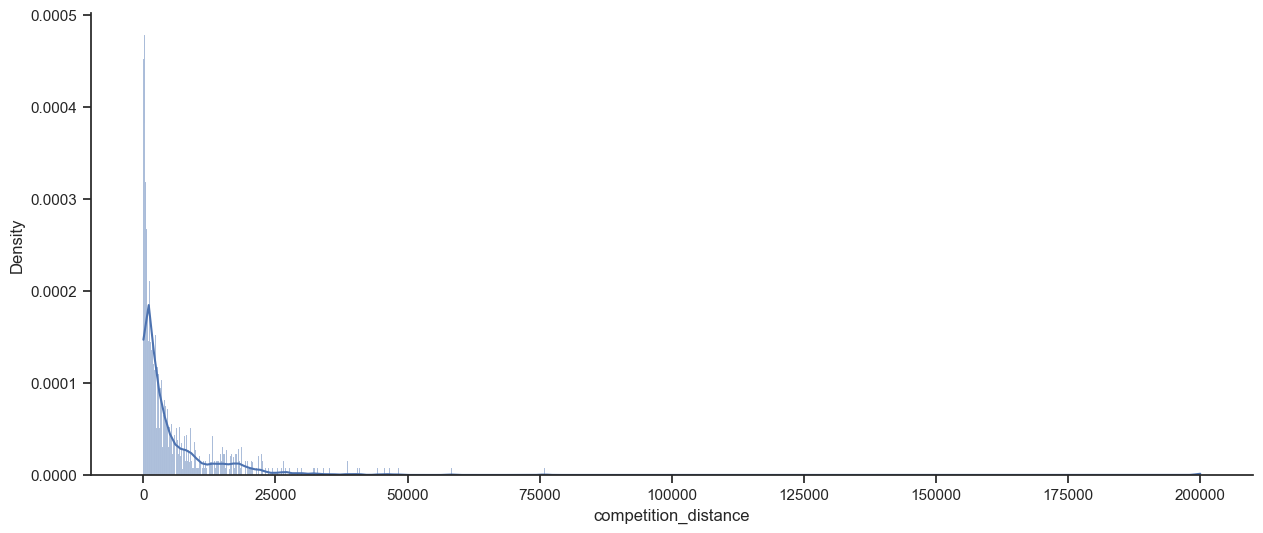

In [17]:
# plt.style.use( 'bmh' )
plt.rcParams['figure.figsize'] = [15, 6]
# plt.rcParams['font.size'] = 14
custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="ticks", rc=custom_params)
    
sns.histplot(df1["competition_distance"], kde=True, stat="density")
plt.show()

### <font color='darkblue'> 1.8.2. Categorical attributes

In [18]:
# checking how many levels each categorical variable has.
cat_attributes.apply( lambda x:x.unique().shape[0] )

state_holiday                    4
store_type                       4
assortment                       3
competition_open_since_month    12
competition_open_since_year     23
promo2_since_week               52
promo2_since_year                7
promo_interval                   4
month_map                       12
dtype: int64

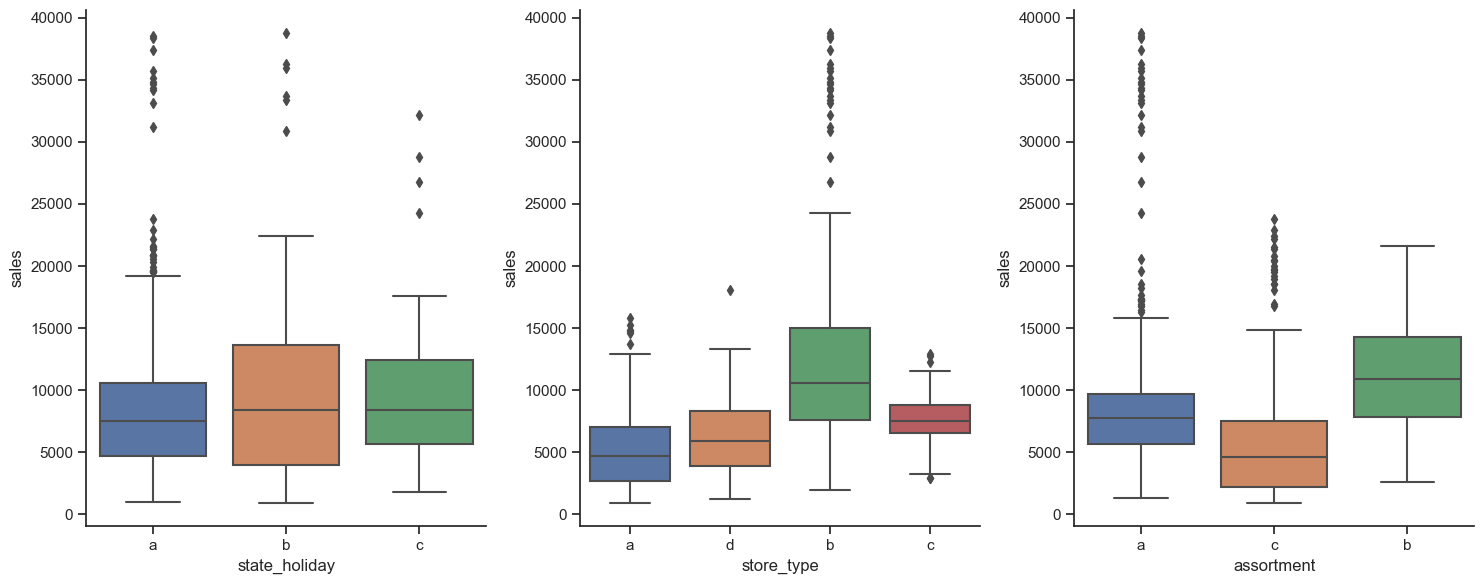

In [19]:
#filtering the days that the store is closed and there was no sales
aux = df1[(df1['state_holiday'] != '0') & (df1['sales'] >0)]

plt.subplot(1, 3, 1)
sns.boxplot(x='state_holiday', y='sales', data=aux)

plt.subplot(1, 3, 2)
sns.boxplot(x='store_type', y='sales', data=aux)

plt.subplot(1, 3, 3)
sns.boxplot(x='assortment', y='sales', data=aux)
plt.tight_layout()

plt.show()

# <font color='darkblue'> 2.0. FEATURE ENGINEERING PROCESS

In [20]:
df2 = df1.copy()

## <font color='darkblue'> 2.1. Mind Map Hypothesis

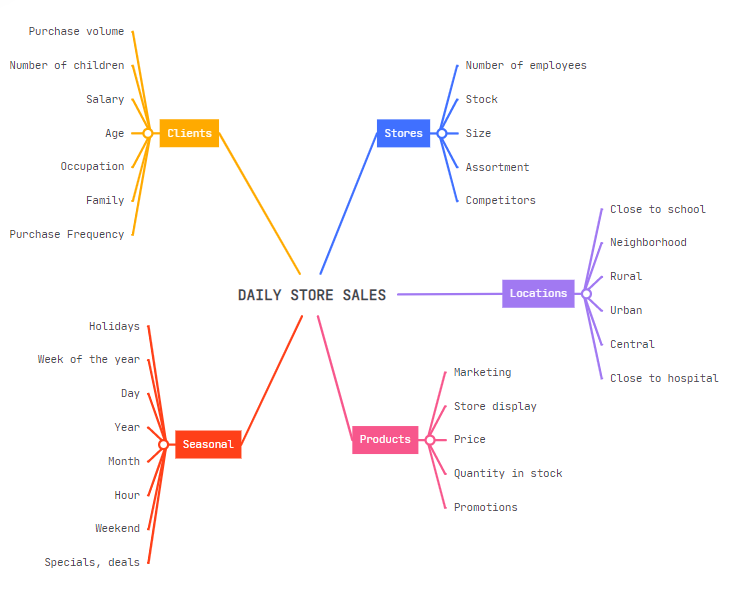

## <font color='darkblue'> 2.2. Hypothesis Creation

### <font color='darkblue'> 2.2.1. STORE brainstorm

**1.** Stores with more employees should sell more.

**2.** Stores with greater inventory capacity should sell more.

**3.** Larger stores should sell more.

**4.** Stores with greater assortments should sell more.

**5.** Stores with closer competitors should sell less.

**6.** Stores with longer competitors should sell more.

### <font color='darkblue'> 2.2.2. PRODUCT brainstorm

**1.** Stores that invest more in Marketing should sell more.

**2.** Stores with greater product exposure should sell more.

**3.** Stores with lower priced products should sell more.

**4.** Stores with more aggressive promotions (bigger discounts) should sell more.

**5.** Stores with promotions active for a longer time should sell more.

**6.** Stores with more promotion days should sell more.

**7.** stores that joined the extended period of promotion sell more.

### <font color='darkblue'> 2.2.3. SEASONALITY brainstorm

**1.** Stores that are opened over the Christmas holiday should sell more.

**2.** Stores should sell more over the years.

**3.** Stores should sell more in the second half of the year.

**4.** Stores should sell more after the 10th of every month.

**5.** Stores should sell less on weekends.

**6.** Stores should sell less during school holidays.

### <font color='darkblue'> 2.2.4. Final list of hypotheses

**This is the set of hypotheses that was prioritized based on the data available for the analysis.**

**1.** Stores with greater assortments should sell more.

**2.** Stores with closer competitors should sell less.

**3.** Stores with competitors for a longer time should sell more.

**4.** Stores with promotions active for a longer time should sell more.

**5.** Stores with more days of promotion should sell more.

**6.** Stores that joined the extended period of promotion sell more.

**7.** Stores that are opened over the Christmas holiday should sell more.

**8.** Stores should sell more over the years.

**9.** Stores should sell more in the second half of the year.

**10.** Stores should sell more after the 10th of every month.

**11.** Stores should sell less on weekends.

**12.** Stores should sell less during school holidays.

## <font color='darkblue'> 2.3. Feature Engineering

In [21]:
#year
df2['year'] = df2['date'].dt.year

#month
df2['month'] = df2['date'].dt.month

#day
df2['day'] = df2['date'].dt.day

#week_of_year
df2['week_of_year'] = df2['date'].dt.weekofyear

#year_week
df2['year_week'] = df2['date'].dt.strftime( '%Y-%W' )

#competition since
df2['competition_since'] = df2.apply(lambda x: datetime.datetime(year=x['competition_open_since_year'], month=x['competition_open_since_month'], day=1), axis=1)
df2['competition_time_month'] = ((df2['date'] - df2['competition_since'])/30).apply(lambda x: x.days).astype(int)
df2['competition_time_month'] = df2['competition_time_month'].astype('int64')


# promo since
df2['promo_since'] = df2['promo2_since_year'].astype( str ) + '-' + df2['promo2_since_week'].astype( str )
df2['promo_since'] = df2['promo_since'].apply( lambda x: datetime.datetime.strptime( x + '-1', '%Y-%W-%w' )-datetime.timedelta( days=7 ) )
df2['promo_time_week'] = ( ( df2['date'] - df2['promo_since'] )/7 ).apply( lambda x: x.days ).astype( int )
df2['promo_time_week'] = df2['promo_time_week'].astype('int64')

# assortment 
df2['assortment'] = df2['assortment'].apply(lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended')

# state holiday
df2['state_holiday'] = df2['state_holiday'].apply(lambda x:'public_holiday' if x == 'a' else 'easter_holiday' if x == 'b' else 'christmas' if x == 'c' else 'regular_day')

# <font color='darkblue'> 3.0. VARIABLE FILTERING

In [22]:
df3 = df2.copy()

## <font color='darkblue'> 3.1. Rows filtering

In [23]:
#removing the days that the store is closed and the ones that sales is > 0
df3 = df3[ (df3['open'] != 0) & (df3['sales'] > 0) ]

## <font color='darkblue'> 3.1. Columns selection

In [24]:
#dropping the coluns that are not going to be used due to business restrictions or were used to create new features 
cols_drop = ['customers', 'open', 'promo_interval', 'month_map']
df3 = df3.drop( cols_drop, axis=1 )

# <font color='darkblue'> 4.0. EXPLORATORY DATA ANALYSIS (EDA)

In [25]:
df4 = df3.copy()

## <font color='darkblue'> 4.1. Univariate analysis

### <font color='darkblue'> 4.1.1. Response variable

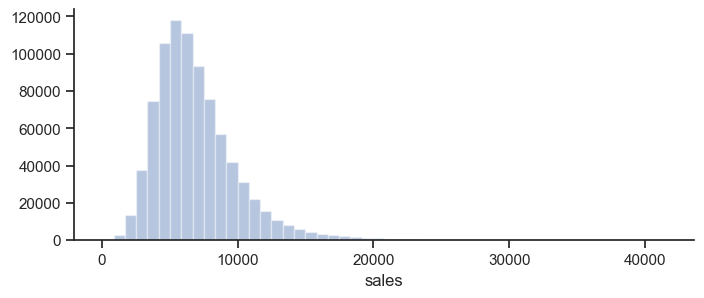

In [26]:
custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="ticks", rc=custom_params)
plt.rcParams['figure.figsize'] = [8, 3]
plt.rcParams['font.size'] = 14

sns.distplot( df4['sales'], kde=False)
plt.show()

### <font color='darkblue'> 4.1.2. Numerical variables

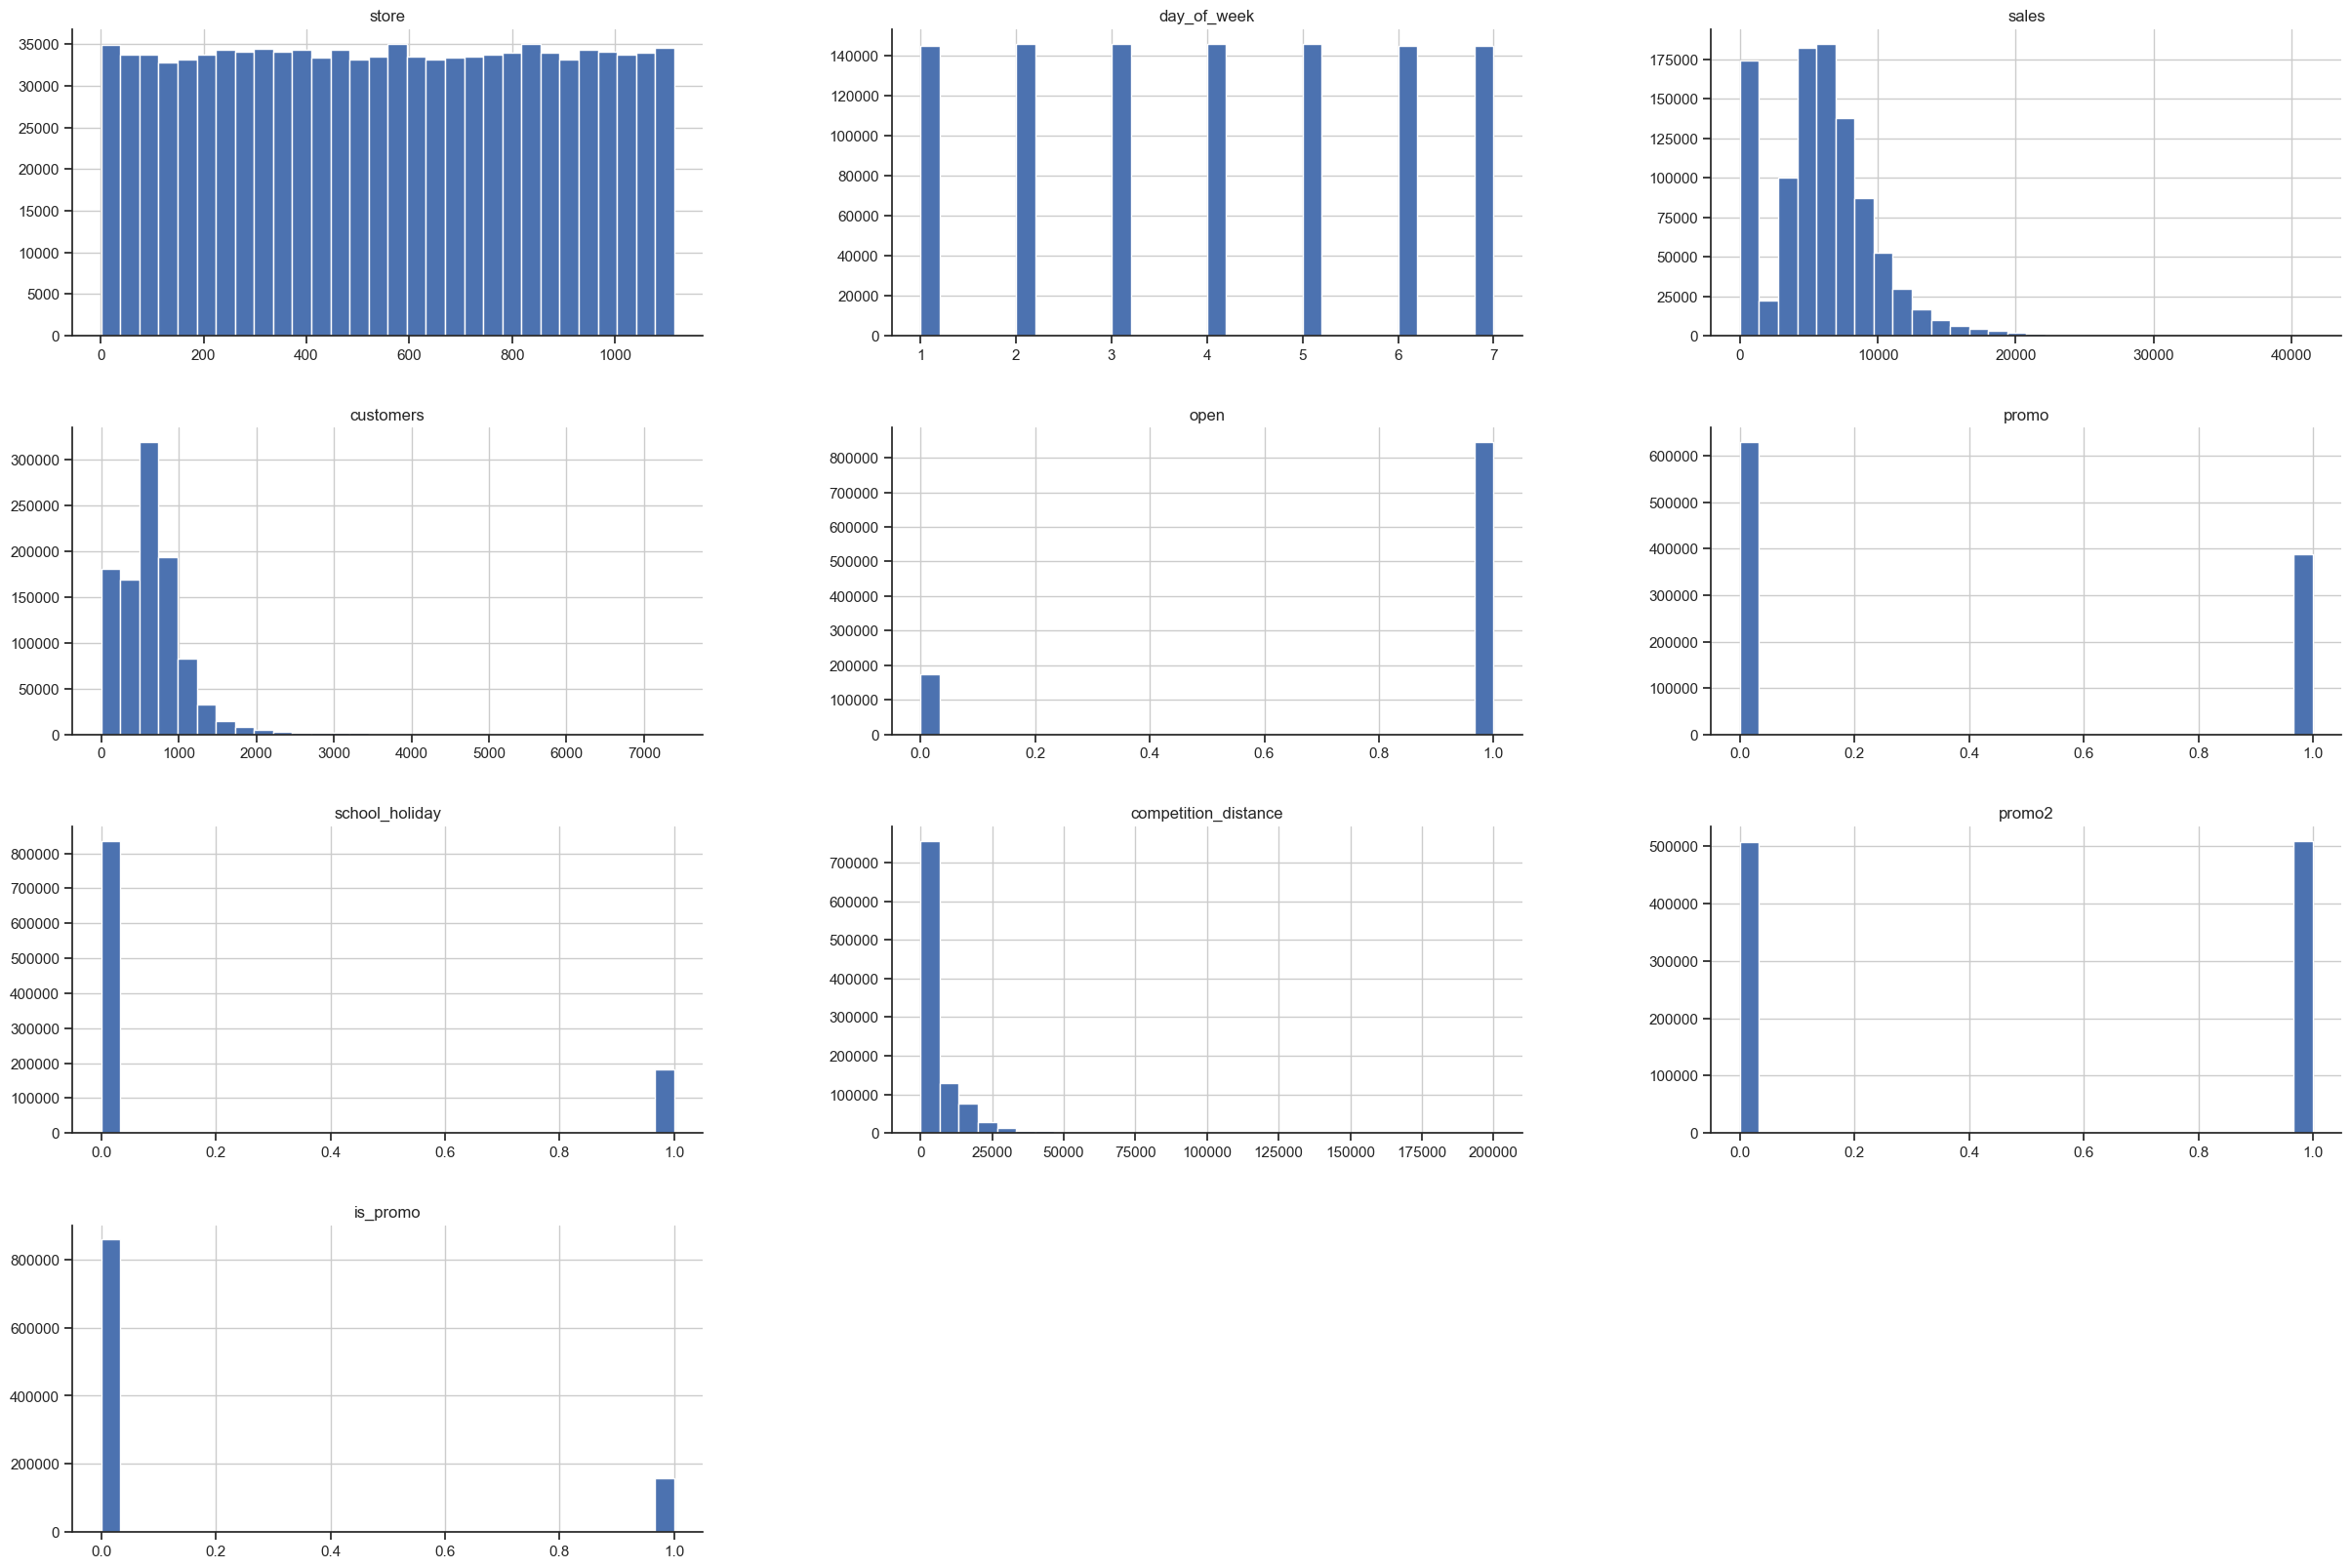

In [27]:
custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="ticks", rc=custom_params)
plt.rcParams['figure.figsize'] = [30, 20]
plt.rcParams['font.size'] = 50

num_attributes.hist(bins=30);

### <font color='darkblue'> 4.1.1. Categorial variables

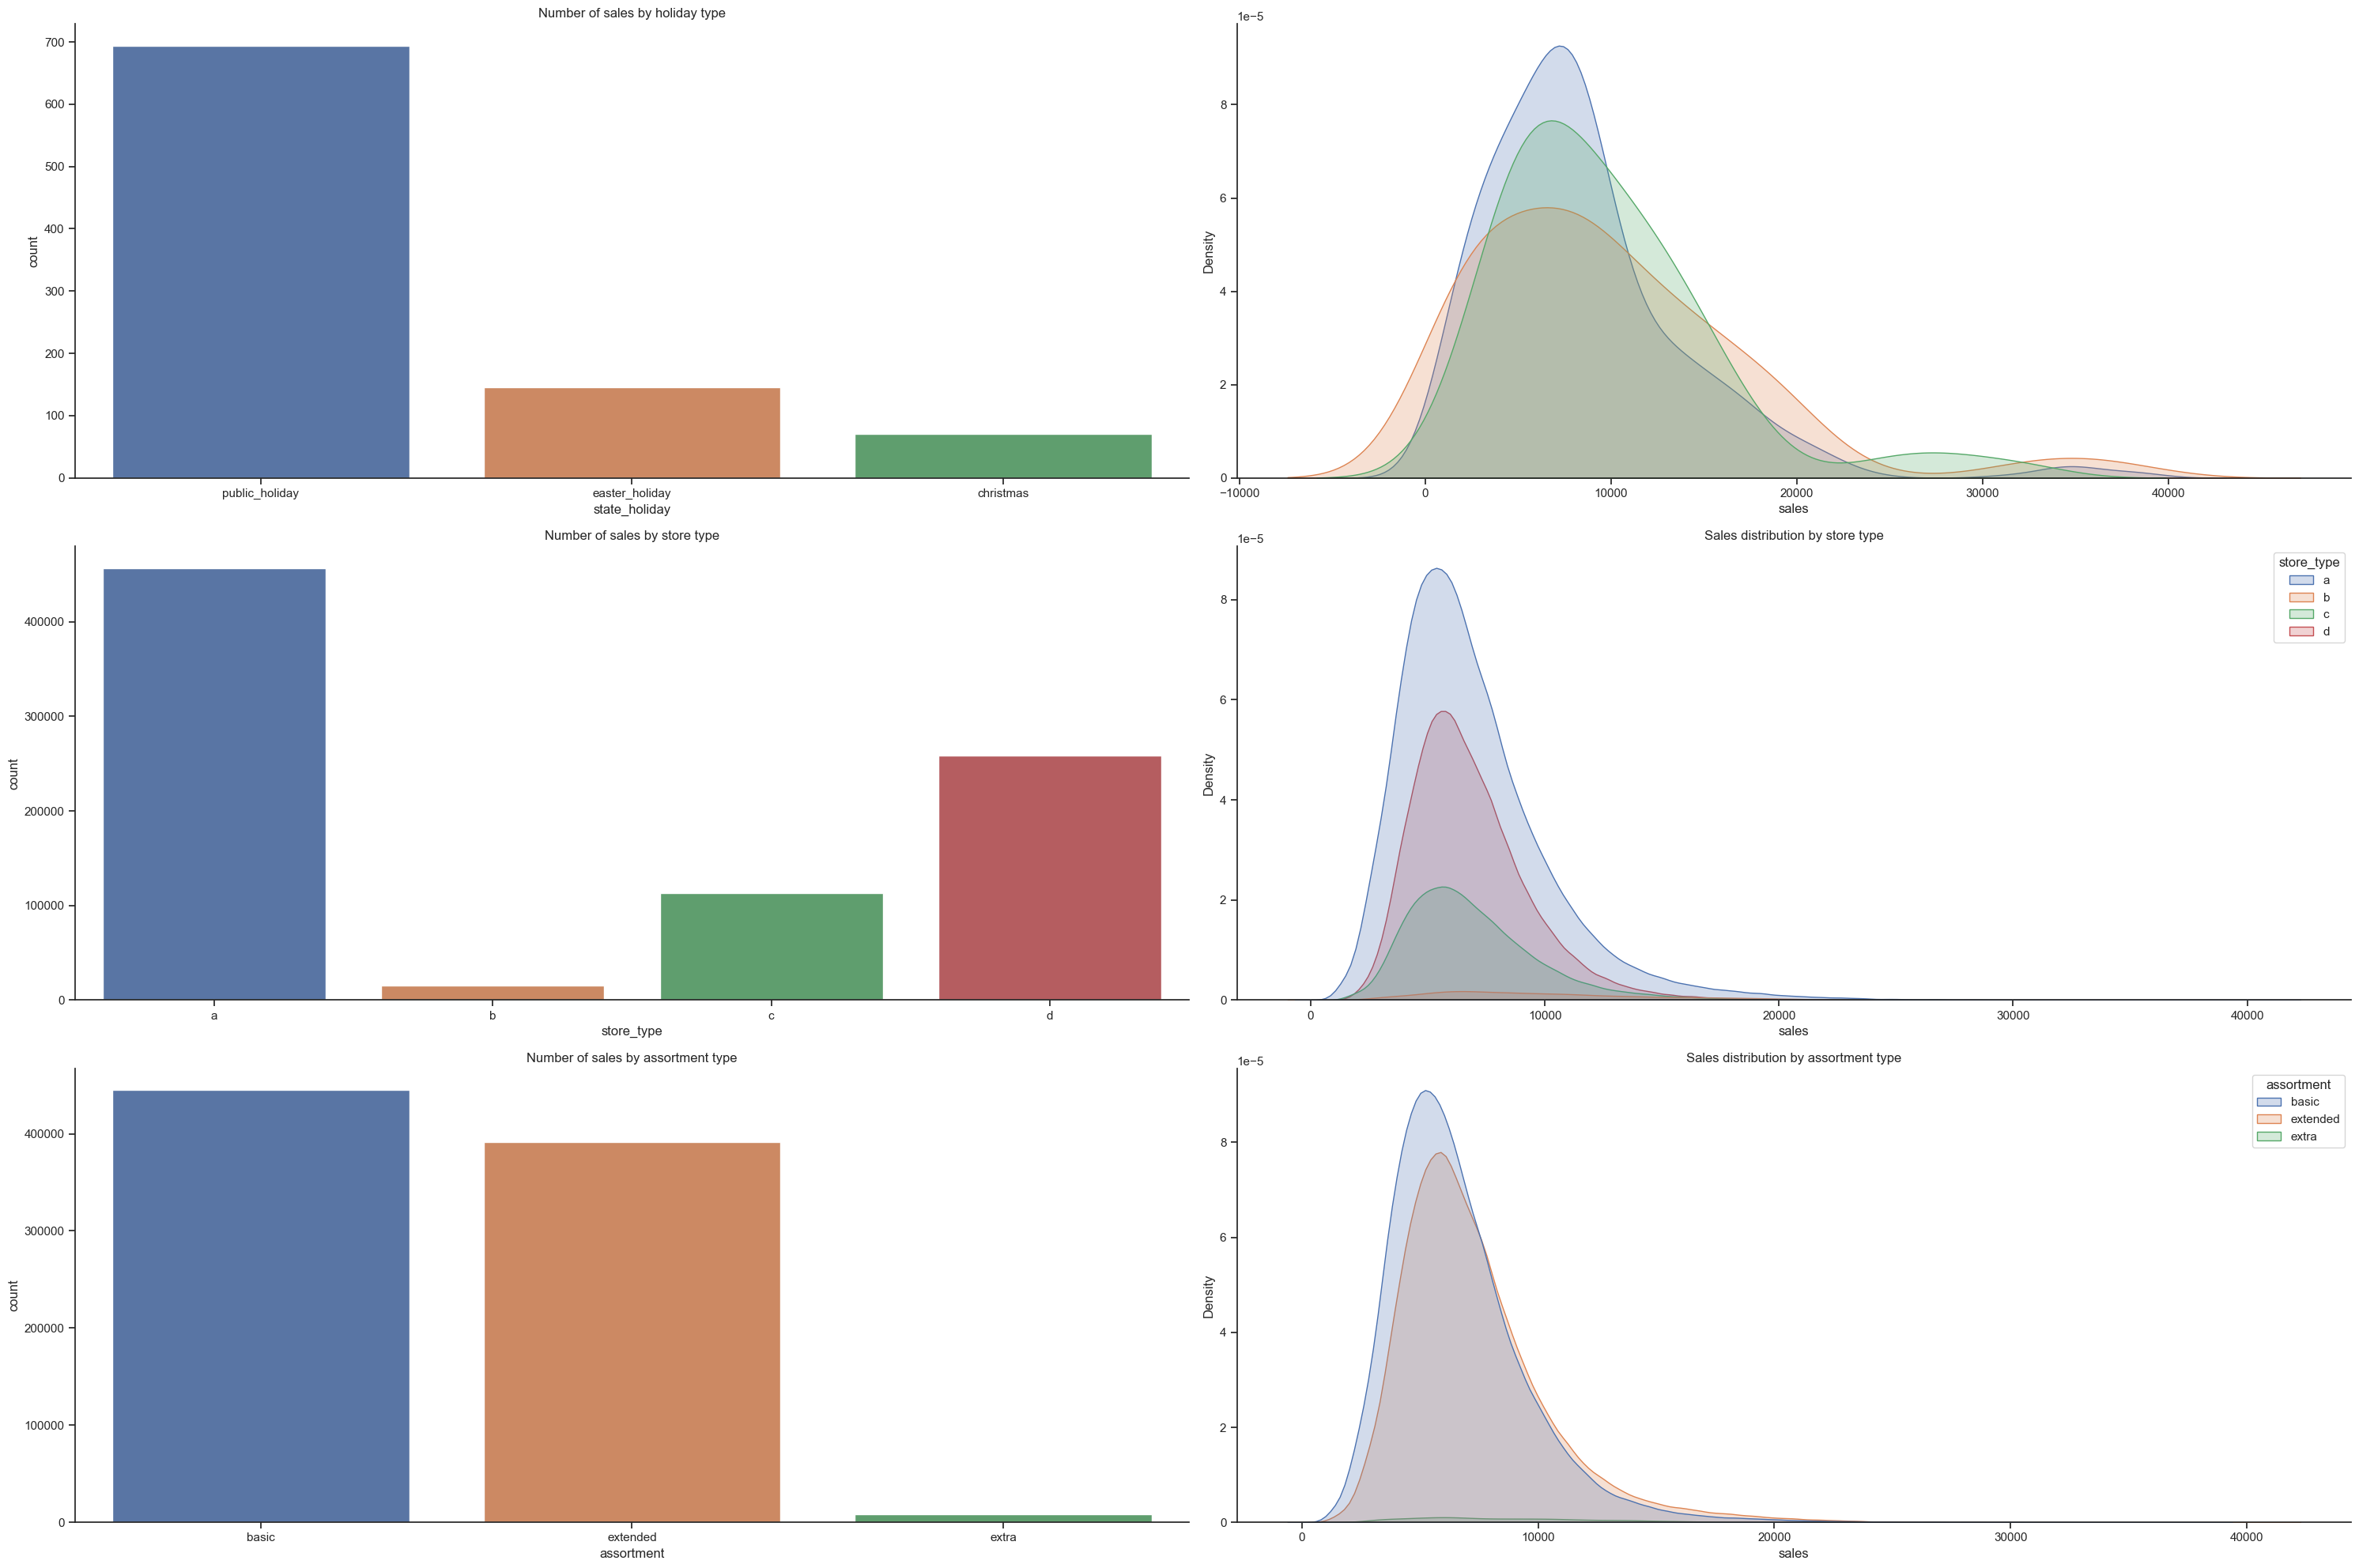

In [28]:
custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="ticks", rc=custom_params)

# sales by 'state_holiday'
plt.subplot(3,2,1)
dt_aux = df4[df4['state_holiday'] != 'regular_day']
sns.countplot(x='state_holiday', data= dt_aux).set_title("Number of sales by holiday type")

plt.subplot(3,2,2)
ph=df4[df4['state_holiday']== 'public_holiday']['sales']
eh=df4[df4['state_holiday']== 'easter_holiday']['sales']
ch=df4[df4['state_holiday']== 'christmas']['sales']

sns.kdeplot(ph,label ='public_holiday',shade =True)
sns.kdeplot(eh,label ='easter_holiday',shade =True)
sns.kdeplot(ch,label ='christmas',shade =True)


# sales by 'store_type'
plt.subplot(3,2,3)
sns.countplot(data=df4, x='store_type', order=['a', 'b', 'c', 'd']).set_title("Number of sales by store type")

plt.subplot(3,2,4)
sns.kdeplot(data=df4, x="sales", hue="store_type", hue_order=['a', 'b', 'c', 'd'], fill=True).set_title("Sales distribution by store type")


# sales by 'assortment'
plt.subplot(3,2,5)
sns.countplot(data=df4, x='assortment', order=['basic', 'extended', 'extra']).set_title("Number of sales by assortment type");

plt.subplot(3,2,6)
sns.kdeplot(data=df4, x="sales", hue="assortment", hue_order=['basic', 'extended', 'extra'], fill=True).set_title("Sales distribution by assortment type");

plt.tight_layout()


## <font color='darkblue'> 4.2. Bivariate analysis

### H1. Stores with greater assortments should sell more.

- <ins>CONCLUSION:</ins> **FALSE** - Stores with greater assortment sell less.
- <ins>RELEVANCE:</ins> **HIGH**

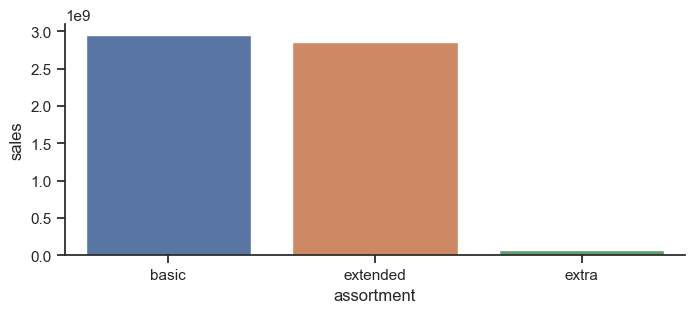

In [29]:
custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="ticks", rc=custom_params)
plt.rcParams['figure.figsize'] = [8, 3]

aux1 = df4[['assortment', 'sales']].groupby('assortment').sum().reset_index()
sns.barplot( data=aux1, x='assortment', y='sales')
sns.set_style("whitegrid")

### H2. Stores with closer competitors should sell less.

- <ins>CONCLUSION:</ins> **FALSE** - Stores with closest competitors sell more.
- <ins>RELEVANCE:</ins> **MEDIUM**

In [30]:
sns.set(rc={'figure.figsize':(25,12)})
sns.set_theme(style = 'darkgrid', font_scale = 1.5) 

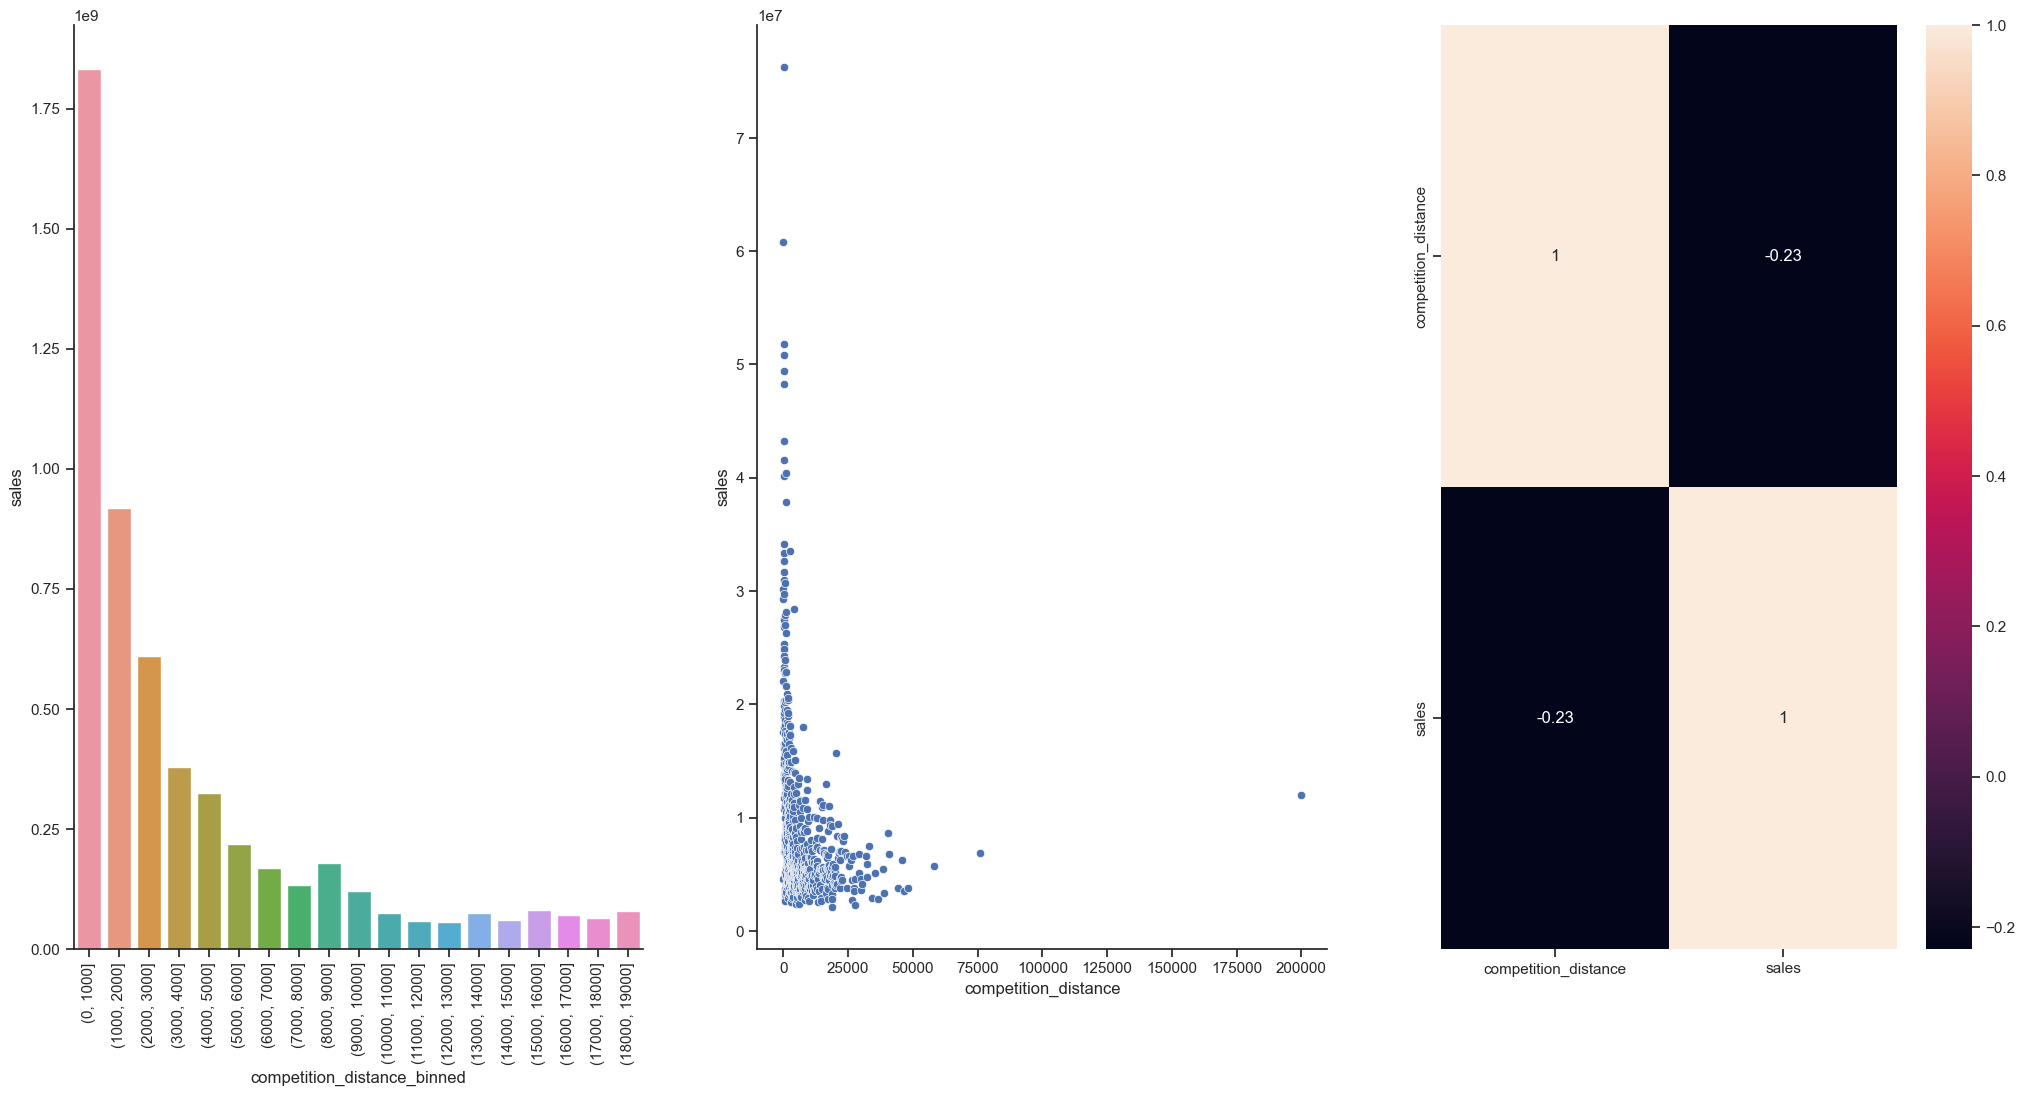

In [31]:
custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="ticks", rc=custom_params)

aux1 = df4[['competition_distance', 'sales']].groupby('competition_distance').sum().reset_index()

plt.tight_layout()

#bar plot
plt.subplot( 1, 3, 1)
bins = list( np.arange( 0, 20000, 1000))
aux1['competition_distance_binned'] = pd.cut( aux1['competition_distance'], bins=bins)
aux2 = aux1[['competition_distance_binned', 'sales']].groupby('competition_distance_binned').sum().reset_index()
sns.barplot( data=aux2, x='competition_distance_binned', y='sales');
plt.xticks( rotation=90)

#scatterplot
plt.subplot( 1, 3, 2)
sns.scatterplot( data=aux1, x='competition_distance', y='sales');

# heatmap (type of correlation)
plt.subplot( 1, 3, 3)
sns.heatmap( aux1.corr( method='pearson'), annot=True);
plt.show()

### H3. Stores with competitors for a longer time should sell more.

- <ins>CONCLUSION:</ins> **FALSE** - Stores with competitors for a longer time sell less.
- <ins>RELEVANCE:</ins> **MEDIUM**

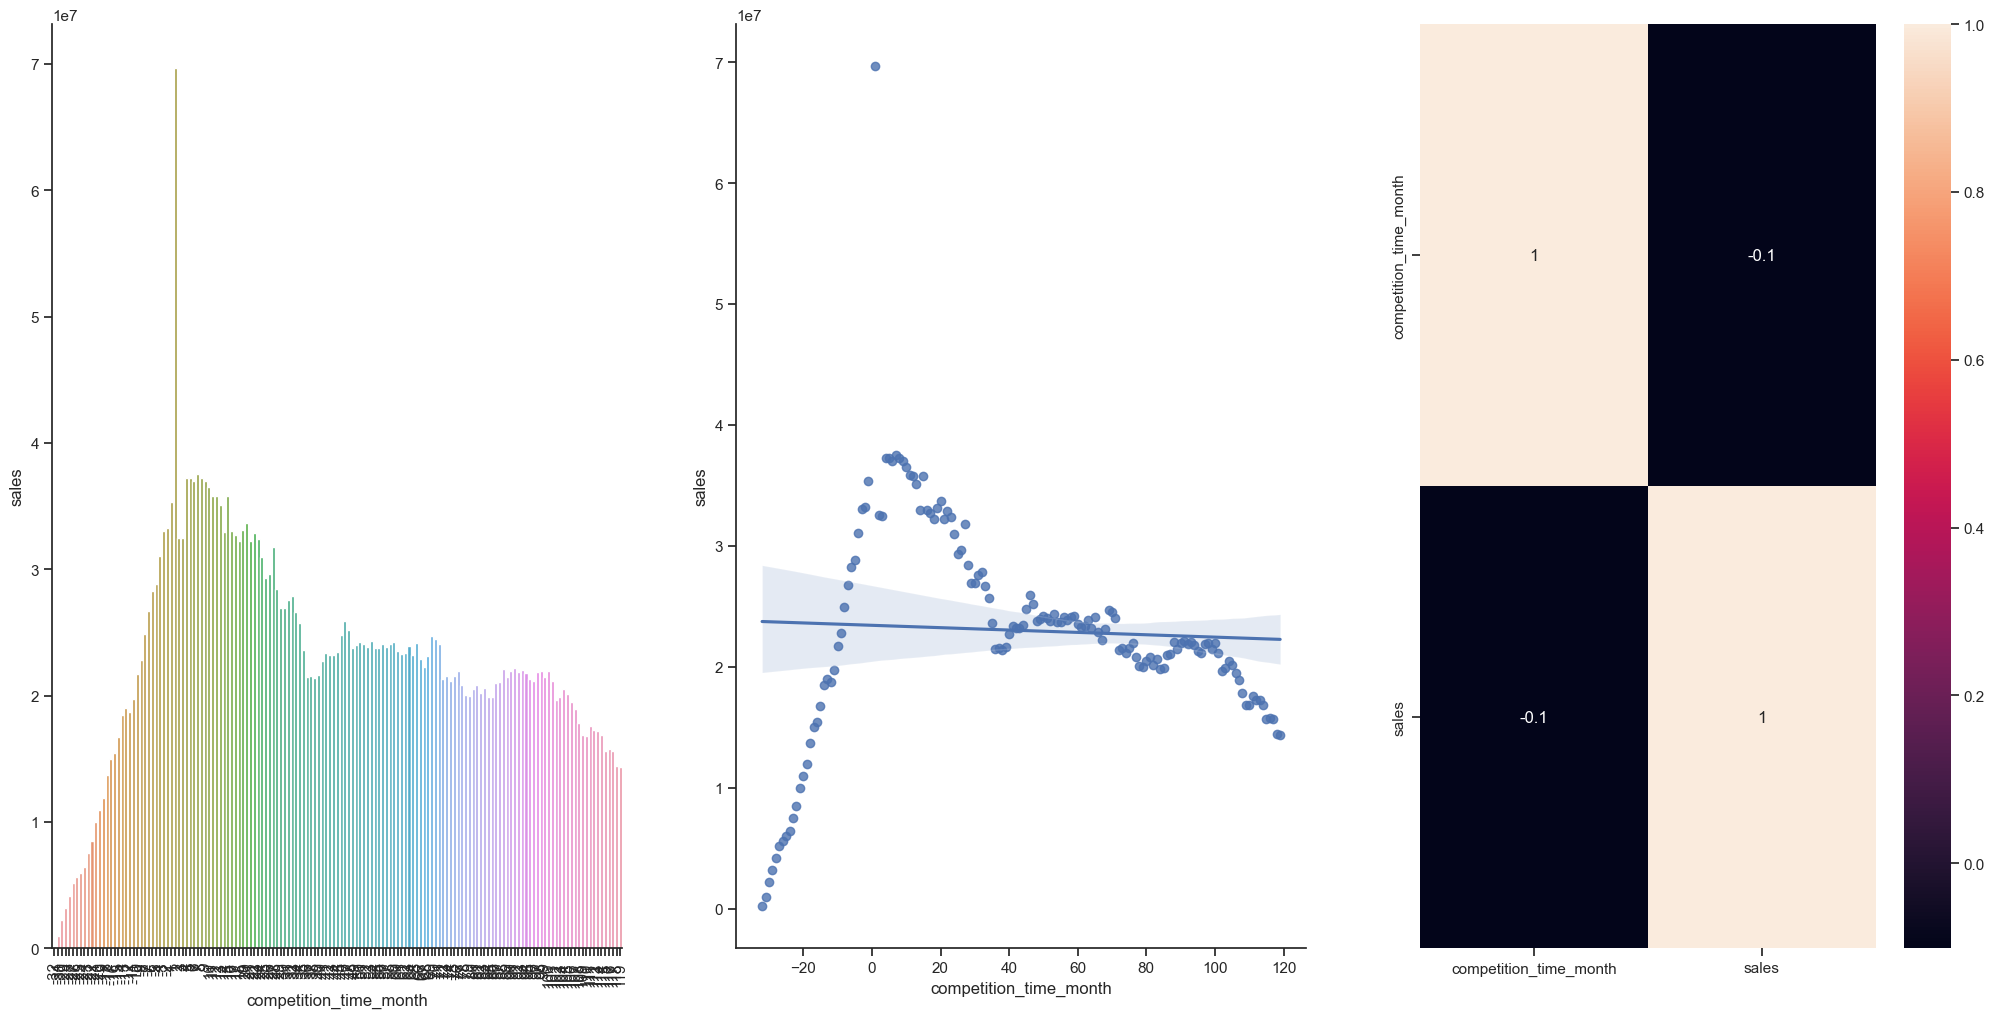

In [32]:
custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="ticks", rc=custom_params)

plt.tight_layout()
aux1 = df4[['competition_time_month', 'sales']].groupby('competition_time_month' ).sum().reset_index()
aux2 = aux1[( aux1['competition_time_month'] < 120 ) & (aux1['competition_time_month'] != 0 )]

plt.subplot( 1, 3, 1 )
sns.barplot( x='competition_time_month', y='sales', data=aux2 );
plt.xticks( rotation=90 );

plt.subplot( 1, 3, 2 )
sns.regplot( x='competition_time_month', y='sales', data=aux2 );

plt.subplot( 1, 3, 3 )
x = sns.heatmap( aux1.corr( method='pearson'), annot=True );
plt.show()

### H4. Stores with promotions active for a longer time should sell more.

- <ins>CONCLUSION:</ins> **FALSE** - Stores with promotions active for longer sell less after a certain period of promotion.
- <ins>RELEVANCE:</ins> **LOW**

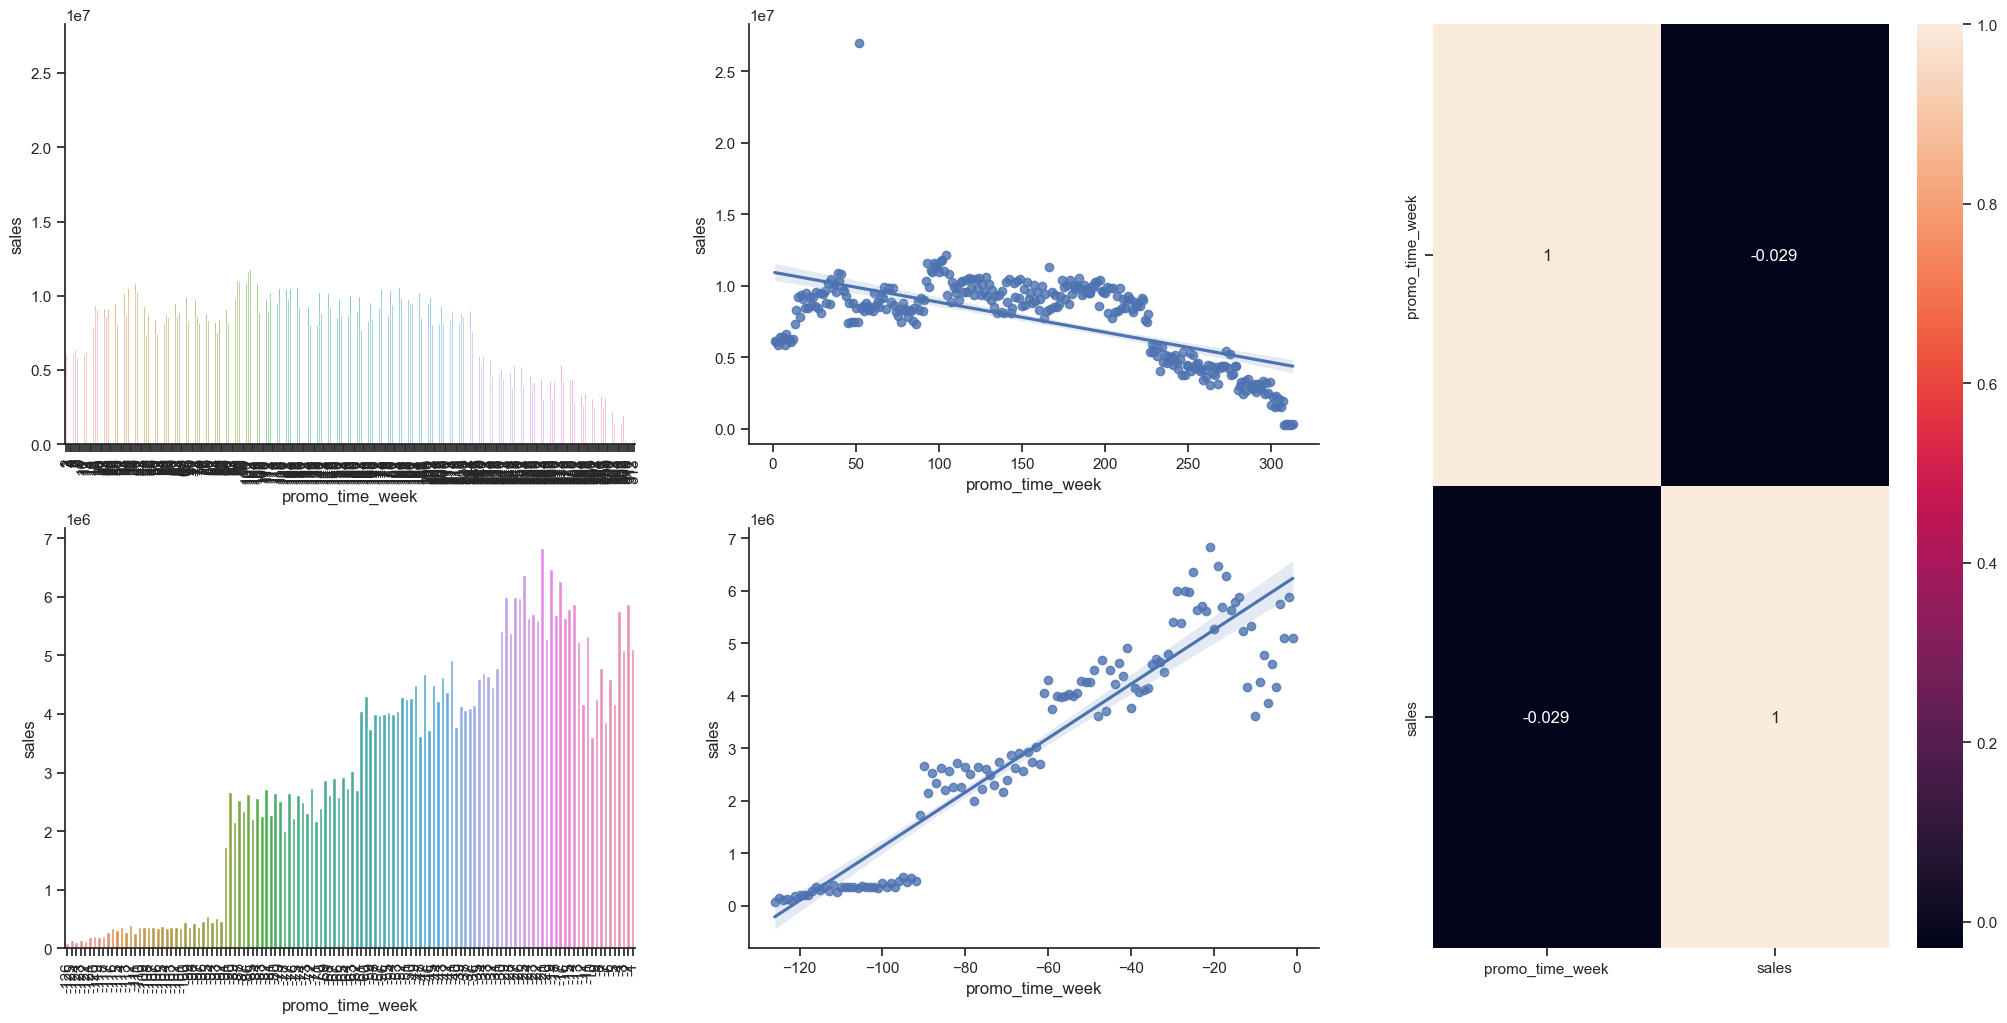

In [33]:
aux1 = df4[['promo_time_week', 'sales']].groupby('promo_time_week').sum().reset_index()

grid = gridspec.GridSpec( 2, 3 )

plt.subplot( grid[0,0] )
aux2 = aux1[aux1['promo_time_week'] > 0] # extended promo period
sns.barplot( x='promo_time_week', y='sales', data=aux2 );
plt.xticks( rotation=90 );

plt.subplot( grid[0,1] )
sns.regplot( x='promo_time_week', y='sales', data=aux2 );
plt.subplot( grid[1,0] )

aux3 = aux1[aux1['promo_time_week'] < 0] # regular promo period
sns.barplot( x='promo_time_week', y='sales', data=aux3 );
plt.xticks( rotation=90 );

plt.subplot( grid[1,1] )
sns.regplot( x='promo_time_week', y='sales', data=aux3 );

plt.subplot( grid[:,2] )
sns.heatmap( aux1.corr( method='pearson' ), annot=True );

### <s> H5. Stores with more days of promotion should sell more. </s>


### H6. Stores that joined the extended period of promotion sell more.

- <ins>CONCLUSION:</ins> **FALSE** - Stores that joined the extended period of promotion sell less.
- <ins>RELEVANCE:</ins> **LOW**

In [34]:
df4[['promo', 'promo2', 'sales']].groupby( ['promo', 'promo2'] ).sum().reset_index()

,promo,promo2,sales
0,0,0,1482612096
1,0,1,1289362241
2,1,0,1628930532
3,1,1,1472275754


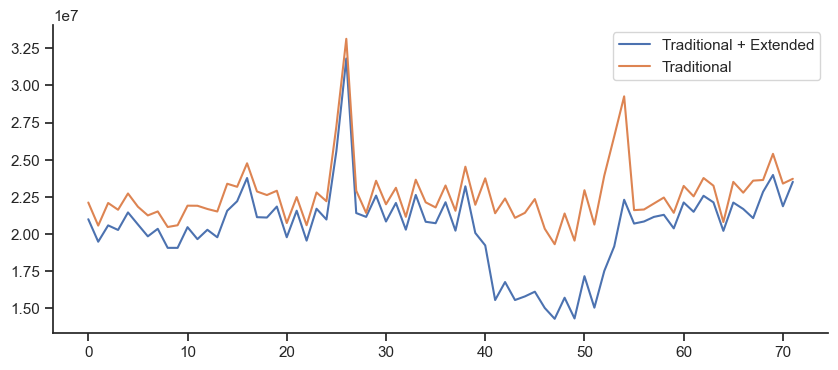

In [35]:
sns.set(rc={'figure.figsize':(10,4)})
sns.set_theme(style="ticks", rc=custom_params, font_scale = 1)

aux1 = df4[( df4['promo'] == 1 ) & ( df4['promo2'] == 1 )][['year_week','sales']].groupby( 'year_week' ).sum().reset_index()

ax = aux1.plot()
aux2 = df4[( df4['promo'] == 1 ) & ( df4['promo2'] == 0 )][['year_week','sales']].groupby( 'year_week' ).sum().reset_index()

aux2.plot( ax=ax )
ax.legend( labels=['Traditional + Extended', 'Traditional']);
plt.show()

### H7. Stores that are opened over the Christmas holiday should sell more.

- <ins>CONCLUSION:</ins> **FALSE** - Stores open during the Christmas holiday sell less.
- <ins>RELEVANCE:</ins> **MEDIUM**

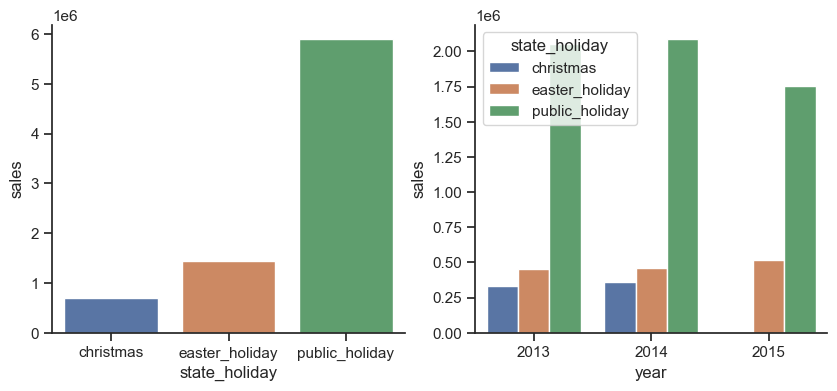

In [36]:
aux = df4[df4['state_holiday'] != 'regular_day']

plt.subplot( 1, 2, 1 )
aux1 = aux[['state_holiday', 'sales']].groupby( 'state_holiday' ).sum().reset_index()
sns.barplot( x='state_holiday', y='sales', data=aux1 );

plt.subplot( 1, 2, 2 )
aux2 = aux[['year', 'state_holiday', 'sales']].groupby( ['year','state_holiday'] ).sum().reset_index()
sns.barplot( x='year', y='sales', hue='state_holiday', data=aux2 );

### H8. Stores should sell more over the years.

- <ins>CONCLUSION:</ins> **FALSE** - Stores sell less over the years.
- <ins>RELEVANCE:</ins> **HIGH**

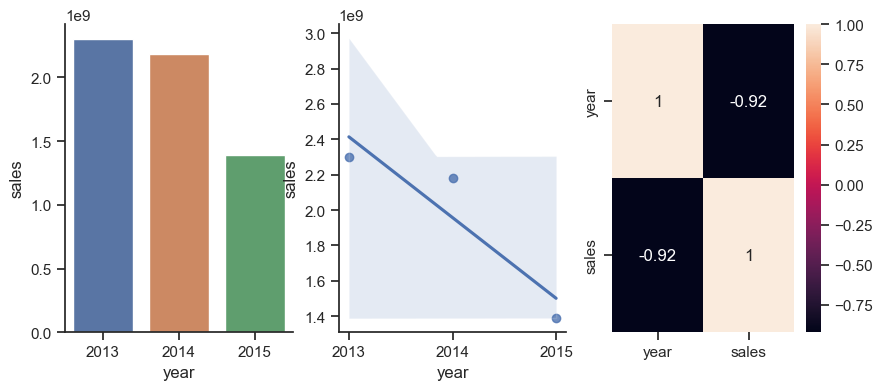

In [37]:
aux1 = df4[['year', 'sales']].groupby( 'year' ).sum().reset_index()

plt.subplot( 1, 3, 1 )
sns.barplot( x='year', y='sales', data=aux1 );

plt.subplot( 1, 3, 2 )
sns.regplot( x='year', y='sales', data=aux1 );

plt.subplot( 1, 3, 3 )
sns.heatmap( aux1.corr( method='pearson' ), annot=True );

### H9. Stores should sell more in the second half of the year.

- <ins>CONCLUSION:</ins> **FALSE** - Stores sell less in the second half of the year.
- <ins>RELEVANCE:</ins> **HIGH**

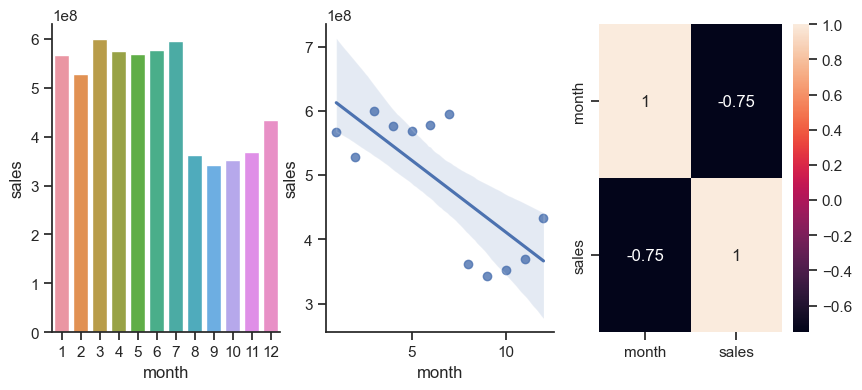

In [38]:
aux1 = df4[['month', 'sales']].groupby( 'month' ).sum().reset_index()

plt.subplot( 1, 3, 1 )
sns.barplot( x='month', y='sales', data=aux1 );

plt.subplot( 1, 3, 2 )
sns.regplot( x='month', y='sales', data=aux1 );

plt.subplot( 1, 3, 3 )
sns.heatmap( aux1.corr( method='pearson' ), annot=True );

### H10. Stores should sell more after the 10th of every month.

- <ins>CONCLUSION:</ins> **TRUE** - Stores sell more after the 10th of each month
- <ins>RELEVANCE:</ins> **HIGH**

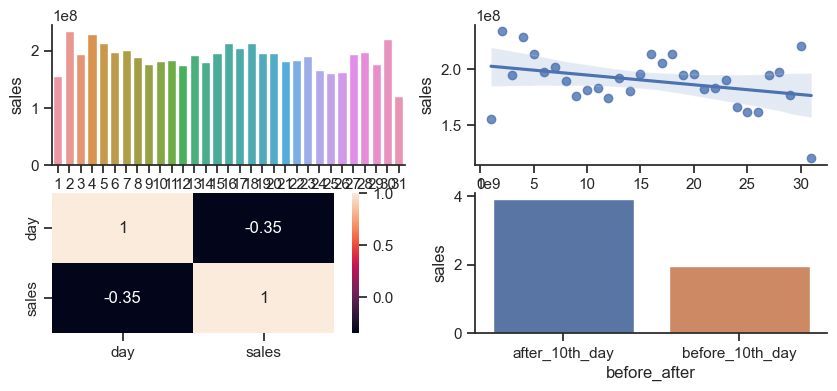

In [39]:
aux1 = df4[['day', 'sales']].groupby( 'day' ).sum().reset_index()

plt.subplot( 2, 2, 1 )
sns.barplot( x='day', y='sales', data=aux1 );

plt.subplot( 2, 2, 2 )
sns.regplot( x='day', y='sales', data=aux1 );

plt.subplot( 2, 2, 3 )
sns.heatmap( aux1.corr( method='pearson' ), annot=True );
aux1['before_after'] = aux1['day'].apply( lambda x: 'before_10th_day' if x <= 10 else 'after_10th_day' )

aux2 =aux1[['before_after', 'sales']].groupby( 'before_after' ).sum().reset_index()

plt.subplot( 2, 2, 4 )
sns.barplot( x='before_after', y='sales', data=aux2 );

### H11. Stores should sell less on weekends.

- <ins>CONCLUSION:</ins> **TRUE** - Stores sell less on weekends.
- <ins>RELEVANCE:</ins> **HIGH**

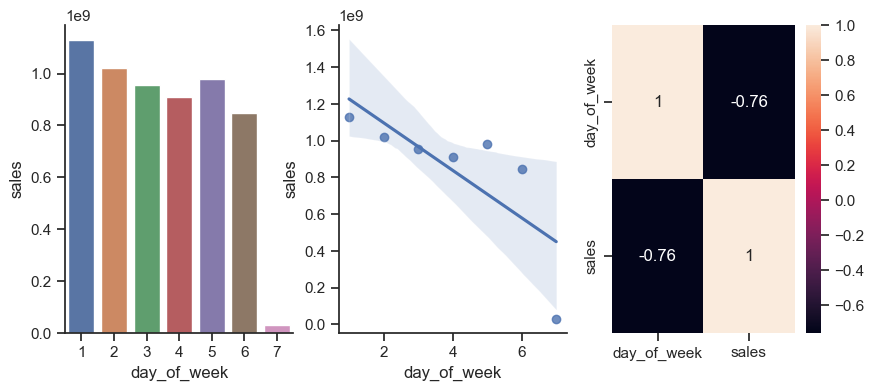

In [40]:
aux1 = df4[['day_of_week', 'sales']].groupby( 'day_of_week' ).sum().reset_index()

plt.subplot( 1, 3, 1 )
sns.barplot( x='day_of_week', y='sales', data=aux1 );

plt.subplot( 1, 3, 2 )
sns.regplot( x='day_of_week', y='sales', data=aux1 );

plt.subplot( 1, 3, 3 )
sns.heatmap( aux1.corr( method='pearson' ), annot=True );

### H12. Stores should sell less during school holidays.

- <ins>CONCLUSION:</ins> **TRUE** - Stores sell less during school holidays, EXCEPT August.
- <ins>RELEVANCE:</ins> **LOW**

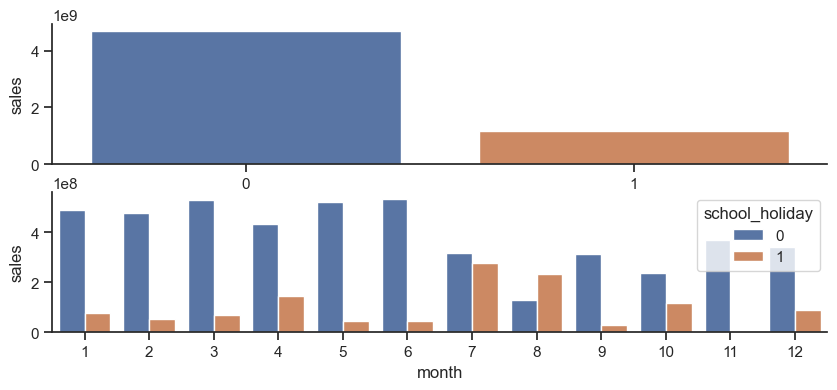

In [41]:
aux1 = df4[['school_holiday', 'sales']].groupby( 'school_holiday' ).sum().reset_index()

plt.subplot( 2, 1, 1 )
sns.barplot( x='school_holiday', y='sales', data=aux1 );

aux2 = df4[['month', 'school_holiday', 'sales']].groupby(['month','school_holiday'] ).sum().reset_index()

plt.subplot( 2, 1, 2 )
sns.barplot( x='month', y='sales', hue='school_holiday', data=aux2 );

### <font color='darkblue'> 4.2.1. Summary of hypotheses.

In [42]:
tab =[
['Hypothesis', 'Conclusion', 'Relevance'],
['H1', 'False', 'Low'],
['H2', 'False', 'Medium'],
['H3', 'False', 'Medium'],
['H4', 'False', 'Low'],
['H5', '-', '-'],
['H6', 'False', 'Low'],
['H7', 'False', 'Medium'],
['H8', 'False', 'High'],
['H9', 'False', 'High'],
['H10', 'True', 'High'],
['H11', 'True', 'High'],
['H12', 'True', 'Low'],
]
print( tabulate( tab, headers='firstrow' ) )

Hypothesis    Conclusion    Relevance
------------  ------------  -----------
H1            False         Low
H2            False         Medium
H3            False         Medium
H4            False         Low
H5            -             -
H6            False         Low
H7            False         Medium
H8            False         High
H9            False         High
H10           True          High
H11           True          High
H12           True          Low


## <font color='darkblue'> 4.3. Multivariate analysis

### <font color='darkblue'> 4.3.1. Numerical attributes

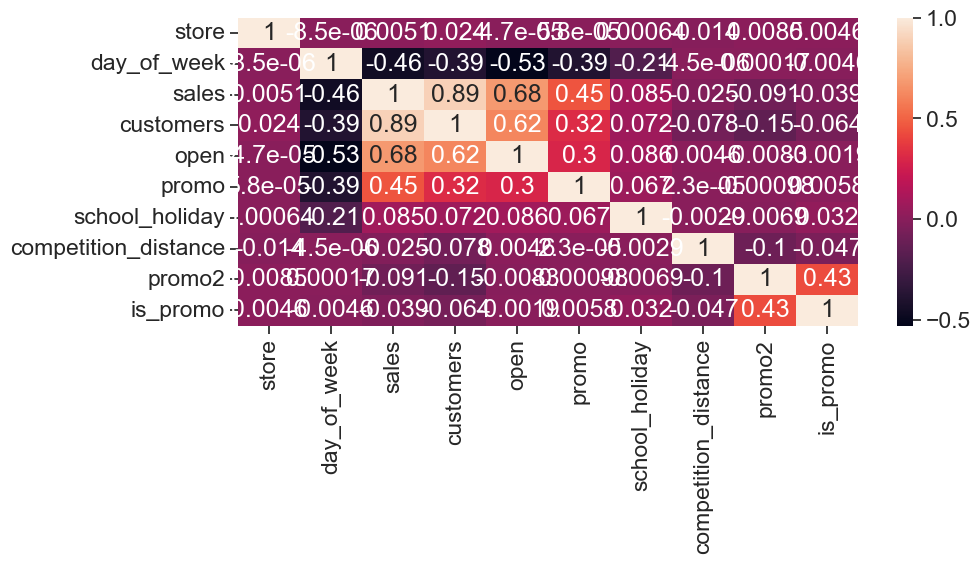

In [43]:
custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="ticks", font_scale=1.5, rc=custom_params)

correlation = num_attributes.corr( method='pearson')
sns.heatmap( correlation, annot=True)
plt.show()

### <font color='darkblue'> 4.3.2. Categorical attributes

In [44]:
# only categorical data
a = df4.select_dtypes( include='object' )

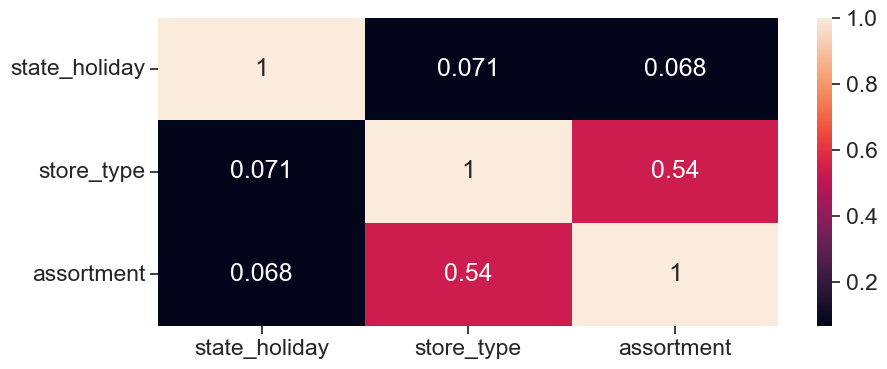

In [45]:
custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="ticks", font_scale=1.5, rc=custom_params)

# calculate cramer V
a1 = cramer_v( a['state_holiday'], a['state_holiday'] )
a2 = cramer_v( a['state_holiday'], a['store_type'] )
a3 = cramer_v( a['state_holiday'], a['assortment'] )
a4 = cramer_v( a['store_type'], a['state_holiday'] )
a5 = cramer_v( a['store_type'], a['store_type'] )
a6 = cramer_v( a['store_type'], a['assortment'] )
a7 = cramer_v( a['assortment'], a['state_holiday'] )
a8 = cramer_v( a['assortment'], a['store_type'] )
a9 = cramer_v( a['assortment'], a['assortment'] )

# Final dataset
d = pd.DataFrame( {'state_holiday': [a1, a2, a3],
'store_type': [a4, a5, a6],
'assortment': [a7, a8, a9] })
d = d.set_index( d.columns )
sns.heatmap( d, annot=True )
plt.show()

####  <font color='red'> Notes

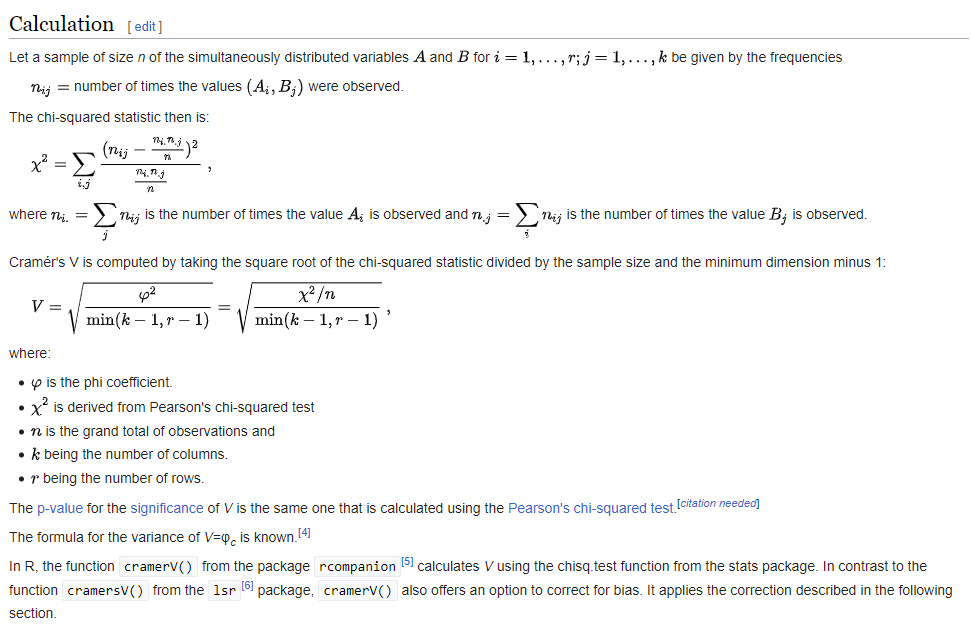

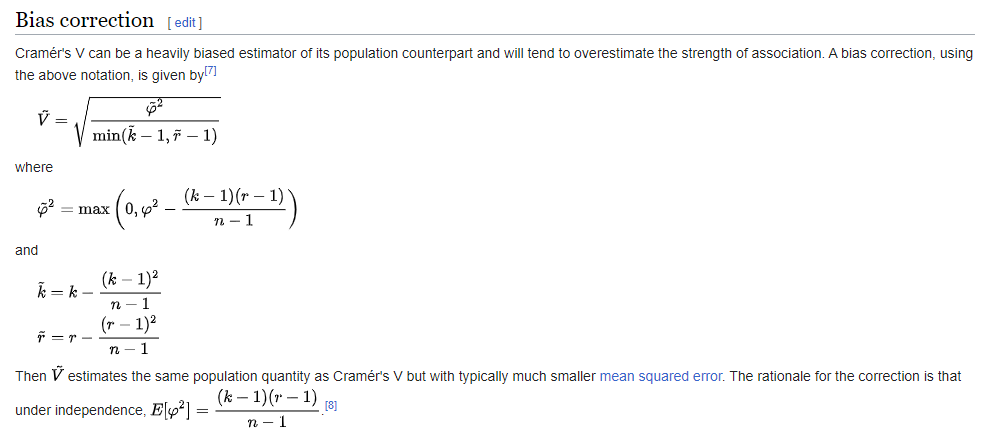

# <font color='darkblue'> 5.0. DATA PREPARATION

In [46]:
df5 = df4.copy()

## <font color='darkblue'> 5.1. Normalization

For this project, there is no variable that has a normal distributions, so this preparation was not applied.

## <font color='darkblue'> 5.2. Scaling

In [47]:
rs  = RobustScaler()
mms = MinMaxScaler()

# competition_distance
df5['competition_distance'] = rs.fit_transform( df5[['competition_distance']].values)
pickle.dump( rs, open("../parameter/competition_distance_scaler.pkl", "wb" ))

# competition time month
df5['competition_time_month'] = rs.fit_transform( df5[['competition_time_month']].values)
pickle.dump( rs, open("../parameter/competition_month_scaler.pkl", "wb" ))

# promo time week
df5['promo_time_week'] = mms.fit_transform( df5[['promo_time_week']].values)
pickle.dump( mms, open("../parameter/promo_time_week_scaler.pkl", "wb" ))

# year
df5['year'] = mms.fit_transform( df5[['year']].values)
pickle.dump( mms, open("../parameter/year_scaler.pkl", "wb" ))

## <font color='darkblue'> 5.3. Transformation

### <font color='darkblue'> 5.3.1. Encoding

In [48]:
#state_holiday - One Hot Encoding
df5 = pd.get_dummies( df5, prefix=['state_holiday'], columns=['state_holiday'] )

#store_type - label Encoding
le=LabelEncoder()
df5['store_type'] = le.fit_transform( df5['store_type'] )
pickle.dump( le, open("../parameter/store_type_encoder.pkl", "wb" ))

#assortment - Ordinal Encoding
assortment_dict = {'basic':1, 'extra':2, 'extended':3}
df5['assortment'] = df5['assortment'].map(assortment_dict)

### <font color='darkblue'> 5.3.2. Response variable transformation

In [49]:
df5['sales'] = np.log1p( df5['sales'] )

### <font color='darkblue'> 5.3.3. Nature transformation

In [50]:
#day_of_week
df5['day_of_week_sin'] = df5['day_of_week'].apply( lambda x: np.sin(x * (2.*np.pi/7 ) ))
df5['day_of_week_cos'] = df5['day_of_week'].apply( lambda x: np.cos(x * (2.*np.pi/7 ) ))

#month
df5['month_sin'] = df5['month'].apply( lambda x: np.sin(x * (2.*np.pi/12 ) ))
df5['month_cos'] = df5['month'].apply( lambda x: np.cos(x * (2.*np.pi/12 ) ))

#day
df5['day_sin'] = df5['day'].apply( lambda x: np.sin(x * (2.*np.pi/30 ) ))
df5['day_cos'] = df5['day'].apply( lambda x: np.cos(x * (2.*np.pi/30 ) ))

#week_of_year
df5['week_of_year_sin'] = df5['week_of_year'].apply( lambda x: np.sin(x * (2.*np.pi/52 ) ))
df5['week_of_year_cos'] = df5['week_of_year'].apply( lambda x: np.cos(x * (2.*np.pi/52 ) ))

# <font color='darkblue'> 6.0. FEATURE SELECTION

In [51]:
df6 = df5.copy()

## <font color='darkblue'> 6.1. Splitting the dataset

In [52]:
# training dataset
X_train = df6[df6['date'] < '2015-06-19']
y_train = X_train['sales']

# test dataset
X_test = df6[df6['date'] >= '2015-06-19']
y_test = X_test['sales']


print( 'Training Min Date: {}'.format( X_train['date'].min() ) )
print( 'Training Max Date: {}'.format( X_train['date'].max() ) )
print( '\nTest Min Date: {}'.format( X_test['date'].min() ) )
print( 'Test Max Date: {}'.format( X_test['date'].max() ) )

Training Min Date: 2013-01-01 00:00:00
Training Max Date: 2015-06-18 00:00:00

Test Min Date: 2015-06-19 00:00:00
Test Max Date: 2015-07-31 00:00:00


In [53]:
cols_drop = ['week_of_year', 'day', 'month', 'day_of_week', 'promo_since', 'competition_since', 'year_week' ]
df6 = df6.drop( cols_drop, axis=1 )

In [54]:
# # spliting the dataset during Data Wrangling step

# cols_drop = ['week_of_year', 'day', 'date' 'month', 'day_of_week', 'promo_since', 'competition_since', 'year_week']


# df7 = df6.drop( cols_drop, axis=1 )

In [55]:
# features = ['store', 'promo', 'school_holiday', 'store_type', 'assortment', 'competition_distance', 
#             'competition_open_since_month', 'competition_open_since_year', 'promo2', 'promo2_since_week', 
#             'promo2_since_year', 'is_promo', 'year', 'competition_time_month', 'promo_time_week', 
#             'state_holiday_christmas', 'state_holiday_easter_holiday', 'state_holiday_public_holiday', 
#             'state_holiday_regular_day', 'day_of_week_sin', 'day_of_week_cos', 'month_sin', 'month_cos', 
#             'day_sin', 'day_cos', 'week_of_year_sin', 'week_of_year_cos']

# label = ['sales']

In [56]:
# X_train = df6.loc[:, features]
# y_train = df6.loc[:, label]

## <font color='darkblue'> 6.2. Boruta as feature selector

### <font color='darkblue'> 6.2.1. Best features from Boruta

In [57]:
# cols_selected = boruta.support_.tolist()
# # best features
# x_train_fs = x_train
# cols_selected_boruta = x_train_fs.iloc[:, cols_selected].columns.to_list()
# # not_selected_boruta 
# cols_not_selected_boruta = list( np.setdiff1d( x_train_fs.columns, cols_selected_boruta ) )

In [58]:
cols_selected_boruta = [
'store',
'promo',
'store_type',
'assortment',
'competition_distance',
'competition_open_since_month',
'competition_open_since_year',
'promo2',
'promo2_since_week',
'promo2_since_year',
'competition_time_month',
'promo_time_week',
'day_of_week_sin',
'day_of_week_cos',
'month_cos',
'day_sin',
'day_cos',
'week_of_year_cos']

In [59]:
cols_not_selected_boruta = [
'is_promo',
'month_sin',
'school_holiday',
'state_holiday_christmas',
'state_holiday_easter_holiday',
'state_holiday_public_holiday',
'state_holiday_regular_day',
'week_of_year_sin',
'year']

## <font color='darkblue'> 6.3. Manual feature selection

In [60]:
# Boruta + Hypothesis
# pega as sugestoes do alguritmo mais o feeling da analise de dados e faz um merge para definir as variaveis
cols_selected = [
'store',
'promo',
'store_type',
'assortment',
'competition_distance',
'competition_open_since_month',
'competition_open_since_year',
'promo2',
'promo2_since_week',
'promo2_since_year',
'competition_time_month',
'promo_time_week',
'day_of_week_sin',
'day_of_week_cos',
'month_sin',
'month_cos',
'day_sin',
'day_cos',
'week_of_year_sin',
'week_of_year_cos']

# columns to add
feat_to_add = ['date', 'sales']
cols_selected_full = cols_selected.copy()
cols_selected_full.extend( feat_to_add )

Em caso de duvida, usa as variaveis sugeridas pelo Boruta no primeiro ciclo e adiciona as que eu acho relevante no ciclo seguinte, nesse caso o 'year'.

# <font color='darkblue'> 7.0. MACHINE LEARNING MODELING

In [61]:
x_train = X_train[cols_selected]
x_test = X_test[cols_selected]

#time series data preparation
x_training = X_train[cols_selected_full]

## <font color='darkblue'> 7.1. Average Model

In [62]:
aux1 = x_test.copy()
aux1['sales'] = y_test.copy()

# prediction
aux2 = aux1[['store', 'sales']].groupby( 'store' ).mean().reset_index().rename(columns={'sales': 'predictions'} )
aux1 = pd.merge( aux1, aux2, how='left', on='store' )
yhat_baseline = aux1['predictions'] 

# performance
baseline_result = ml_error( 'Average Model', np.expm1( y_test ), np.expm1(yhat_baseline ) )
baseline_result

,Model Name,MAE,MAPE,RMSE
0,Average Model,1354.800353,0.2064,1835.135542


## <font color='darkblue'> 7.2. Linear Regression Model

In [72]:
# model
lr = LinearRegression().fit( x_train, y_train )

# prediction
yhat_lr = lr.predict( x_test )

# performance
lr_result = ml_error( 'Linear Regression', np.expm1( y_test ), np.expm1(yhat_lr ) )
lr_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regression,1867.089774,0.292694,2671.049215


### <font color='darkblue'> 7.2.1. Linear Regression Model - Cross Validation

In [64]:
# lr_result_cv = cross_validation( x_training, 5, "Linear Regression", lr,verbose=False )
# lr_result_cv

## <font color='darkblue'> 7.3. Linear Regression Regularized Model - Lasso

In [73]:
# model
lrr = Lasso(alpha=0.0001).fit( x_train, y_train )

# prediction
yhat_lrr = lr.predict( x_test )

# performance
lrr_result = ml_error( 'Linear Regression Lasso', np.expm1( y_test ), np.expm1(yhat_lrr ) )
lrr_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regression Lasso,1867.089774,0.292694,2671.049215


### <font color='darkblue'> 7.3.1. Lasso Model - Cross Validation

In [66]:
# lrr_result_cv = cross_validation( x_training, 5, "Lasso", lrr,verbose=False )
# lrr_result_cv

## <font color='darkblue'> 7.4. Random Forest Regressor

In [74]:
# model
rf = RandomForestRegressor( n_estimators=100, n_jobs=-1, random_state=42 ).fit( x_train, y_train )

# prediction
yhat_rf = rf.predict( x_test )

# performance
rf_result = ml_error( 'Random Forest Regressor', np.expm1( y_test ), np.expm1(yhat_rf ) )
rf_result

,Model Name,MAE,MAPE,RMSE
0,Random Forest Regressor,679.598831,0.099913,1011.119437


### <font color='darkblue'> 7.4.1. Random Forest Regressor Model - Cross Validation

In [68]:
# rf_result_cv = cross_validation( x_training, 5, 'Random Forest Regressor', rf, verbose=True )
# rf_result_cv

## <font color='darkblue'> 7.5. XGBoost Regressor

In [69]:
xgb = XGBRegressor().fit( x_train, y_train )

# prediction
yhat_xgb = xgb.predict( x_test )

# performance
xgb_result = ml_error( 'XGBoost Regressor', np.expm1( y_test ), np.expm1(yhat_xgb ) )
xgb_result

,Model Name,MAE,MAPE,RMSE
0,XGBoost Regressor,868.958205,0.130309,1238.550843


### <font color='darkblue'> 7.5.1. XGBoost Regressor Model - Cross Validation

In [70]:
xgb_result_cv = cross_validation( x_training, 5, 'XGBoost Regressor', xgb, verbose=True)
xgb_result_cv


KFold Number: 5

KFold Number: 4

KFold Number: 3

KFold Number: 2

KFold Number: 1


,Model Name,MAE CV,MAPE CV,RMSE CV
0,XGBoost Regressor,1064.94 +/- 178.65,0.15 +/- 0.02,1519.92 +/- 242.12


## <font color='darkblue'> 7.6. Compare models' performance

### <font color='darkblue'> 7.6.1. Single performance

In [75]:
modelling_result = pd.concat( [baseline_result, lr_result, lrr_result, rf_result, xgb_result] )
modelling_result.sort_values( 'RMSE' )

,Model Name,MAE,MAPE,RMSE
0,Random Forest Regressor,679.598831,0.099913,1011.119437
0,XGBoost Regressor,868.958205,0.130309,1238.550843
0,Average Model,1354.800353,0.206400,1835.135542
0,Linear Regression,1867.089774,0.292694,2671.049215
0,Linear Regression Lasso,1867.089774,0.292694,2671.049215


### <font color='darkblue'> 7.6.2. Real performance - Cross Validation

In [ ]:
# modelling_result_cv = pd.concat( [ lr_result_cv, lrr_result_cv, rf_result_cv, xgb_result_cv] )
# modelling_result_cv.sort_values( 'RMSE CV' )

In [76]:
def cross_validation( x_training, kfold, model_name, model):
    mae_list = []
    mape_list = []
    rmse_list = []
    for k in reversed( range( 1, kfold+1) ):
        print(f'\nkFold Number: {k}')
        
        #start and end date for validation
        validation_start_date = x_training['date'].max() - datetime.timedelta(weeks=k*6)
        validation_end_date = x_training['date'].max() - datetime.timedelta(weeks=(k-1)*6)

        #filtering dataset
        training = x_training[x_training['date'] < validation_start_date]
        validation = x_training[(x_training['date'] >= validation_start_date) & (x_training['date'] <= validation_end_date)]   

        # training and validation dataset
        #training
        xtraining = training.drop(['date', 'sales'], axis=1)
        ytraining = training['sales']

        #validation
        xvalidation = validation.drop(['date', 'sales'], axis=1)
        yvalidation = validation['sales']

        # model
        m = model.fit( xtraining, ytraining)

        # prediction
        yhat = m.predict( xvalidation )
        
        #performance
        m_result = ml_error( model_name, np.expm1( yvalidation ), np.expm1(yhat_lr ) )
        
        # store the of each kfold iteration
        mae_list.append( m_result['MAE'] )
        mape_list.append( m_result['MAPE'] )
        rmse_list.append( m_result['RMSE'] )

    return pd.DataFrame( {'Model Name': model_name, 
                      'MAE CV': np.round( np.mean( mae_list ), 2 ).astype(str ) + ' +/- ' + np.round( np.std( mae_list ), 2 ).astype( str ),
                      'MAPE CV': np.round( np.mean( mape_list ), 2 ).astype( str ) + ' +/- ' + np.round( np.std( mape_list ), 2 ).astype( str ),
                      'RMSE CV': np.round( np.mean( rmse_list ), 2 ).astype( str ) + ' +/- ' + np.round( np.std( rmse_list ), 2 ).astype( str )}, index=[0] )

# <font color='darkblue'> 8.0. HYPERPARAMETER FINE TUNING

## <font color='darkblue'> 8.1. Random Search

In [ ]:
# param = {
# 'n_estimators': [1500, 1700, 2500, 3000, 3500],
# 'eta': [0.01, 0.03],
# 'max_depth': [3, 5, 9],
# 'subsample': [0.1, 0.5, 0.7],
# 'colsample_bytree': [0.3, 0.7, 0.9],
# 'min_child_weight': [3, 8, 15]
# }

# MAX_EVAL = 10

In [ ]:
# final_result = pd.DataFrame()

# for i in range( MAX_EVAL ):
#     # choose values for parameters randomly
#     hp = { k: random.sample( v, 1 )[0] for k, v in param.items() }
#     print( hp )
    
#     #model
#     xgb = XGBRegressor( objective='reg:squarederror',
#                         n_estimators=hp['n_estimators'],
#                         eta=hp['eta'],
#                         max_depth=hp['max_depth'],
#                         subsample=hp['subsample'],
#                         colsample_bytree=hp['colsample_bytree'],
#                         min_child_weight=hp['min_child_weight'] )
    
#     #performance
#     result = cross_validation( x_training, 5, 'XGBoost Regressor', xgb, verbose=True )
#     final_result = pd.concat( [final_result, result] )

# final_result

In [ ]:
x_training[x_training.index.duplicated()]

## <font color='darkblue'> 8.2. Final Model

In [77]:
param_tuned = {
    'n_estimators': 1700,
    'eta': 0.01,
    'max_depth': 9,
    'subsample': 0.5,
    'colsample_bytree': 0.7,
    'min_child_weight': 8, 
    }

In [79]:
# model
model_xgb_tuned = XGBRegressor( objective='reg:squarederror',
                    n_estimators=param_tuned ['n_estimators'],
                    eta=param_tuned ['eta'],
                    max_depth=param_tuned ['max_depth'],
                    subsample=param_tuned ['subsample'],
                    colsample_bytree=param_tuned ['colsample_bytree'],
                    min_child_weight=param_tuned ['min_child_weight']).fit( x_train, y_train )

# prediction
yhat_model_xgb_tuned = model_xgb_tuned.predict( x_test )


# performance
xgb_result_tuned = ml_error( 'XGBoost Regressor', np.expm1( y_test ), np.expm1(yhat_model_xgb_tuned ) )

xgb_result_tuned

,Model Name,MAE,MAPE,RMSE
0,XGBoost Regressor,786.90743,0.11579,1150.51646


In [80]:
yhat_model_xgb_tuned.sum()

362839.56

In [81]:
mpe = mean_percentage_error( np.expm1 (y_test), np.expm1( yhat_model_xgb_tuned ) )
mpe

-0.00872197222101128

# <font color='darkblue'> 9.0. ERROR TRANSLATION AND INTERPRETATION

In [82]:
df9 = X_test[cols_selected_full]

# rescale
df9['sales'] = np.expm1( df9['sales'] )
df9['predictions'] = np.expm1( yhat_model_xgb_tuned )

## <font color='darkblue'> 9.1. Business performance

In [83]:
# sum of predictions
df91 = ( df9[['store', 'predictions']].groupby( 'store' )
                                    .sum()
                                    .reset_index() )

# MAE and MAPE
df9_aux1 = ( df9[['store', 'sales', 'predictions']].groupby( 'store' )
                                                   .apply(lambda x: mean_absolute_error( x['sales'], x['predictions'] ) )
                                                   .reset_index()
                                                   .rename( columns={0:'MAE'}) )
            
df9_aux2 = ( df9[['store', 'sales', 'predictions']].groupby( 'store' )
                                                 .apply(lambda x: mean_absolute_percentage_error( x['sales'], x['predictions'] ) )
                                                .reset_index()
                                                .rename( columns={0:'MAPE'}) )

# merge
df9_aux3 = pd.merge( df9_aux1, df9_aux2, how='inner', on='store' )
df92 = pd.merge( df91, df9_aux3, how='inner', on='store' )

# scenarios
df92['worst_scenario'] = df92['predictions'] - df92['MAE']
df92['best_scenario'] = df92['predictions'] + df92['MAE']

# ordering columns
df92 = df92[['store', 'predictions', 'worst_scenario', 'best_scenario', 'MAE','MAPE']]

In [84]:
df92['predictions'].sum()

281935550.0

In [85]:
df92.sort_values( 'MAPE', ascending=True).sample(5)

,store,predictions,worst_scenario,best_scenario,MAE,MAPE
283,284,218521.031250,217856.062078,219186.000422,664.969172,0.130471
314,315,170692.343750,170323.071909,171061.615591,369.271841,0.100574
570,571,291710.312500,290890.509673,292530.115327,819.802827,0.092919
641,642,144769.875000,144055.173221,145484.576779,714.701779,0.228371
450,451,208245.859375,207644.459196,208847.259554,601.400179,0.104542


In [86]:
df92.sort_values( 'MAPE', ascending=False).head()

,store,predictions,worst_scenario,best_scenario,MAE,MAPE
291,292,111155.328125,107660.222451,114650.433799,3495.105674,0.639785
908,909,216326.515625,208320.168330,224332.862920,8006.347295,0.522264
285,286,188098.140625,186702.163937,189494.117313,1395.976688,0.480321
594,595,323691.093750,318136.447437,329245.740063,5554.646313,0.382284
424,425,157582.015625,156486.825849,158677.205401,1095.189776,0.379940


In [87]:
(len(df92[df92['MAPE'] >= 0.20]) / len(df92['MAPE']))*100

4.843049327354261

In [88]:
len(df92[df92['MAPE'] >= 0.20])

54

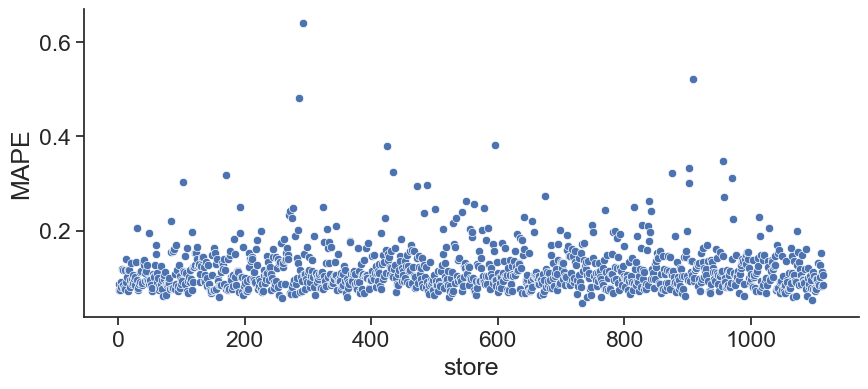

In [89]:
sns.scatterplot( x='store', y='MAPE', data=df92)
plt.show()

## <font color='darkblue'> 9.2. Total performance

In [90]:
df93 = ( df92[['predictions', 'worst_scenario', 'best_scenario']].apply( lambda x:np.sum( x ), axis=0 )
                                                                 .reset_index()
                                                                 .rename( columns={'index': 'Scenario', 0:'Values'} ) )
df93['Values'] = df93['Values'].map( '${:,.2f}'.format )        
df93

,Scenario,Values
0,predictions,"$281,935,552.00"
1,worst_scenario,"$281,054,909.81"
2,best_scenario,"$282,816,213.30"


## <font color='darkblue'> 9.3. Machine learning performance

In [91]:
df9['error'] = df9['sales'] - df9['predictions']
df9['error_rate'] = df9['predictions'] / df9['sales']

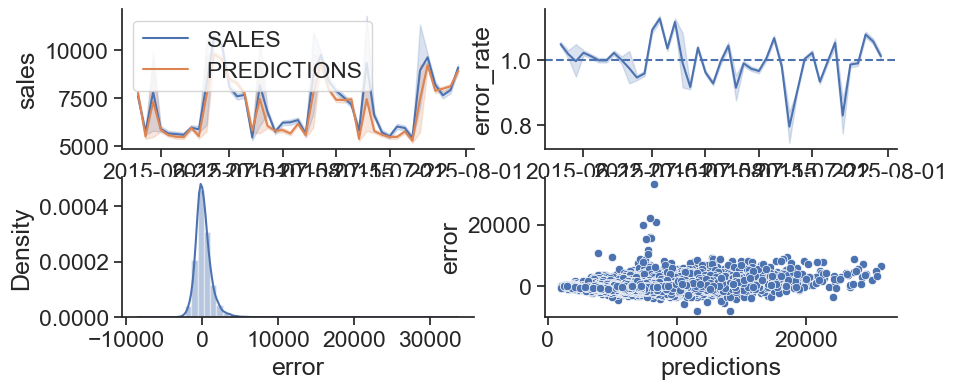

In [92]:
plt.subplot( 2, 2, 1 )
sns.lineplot( x='date', y='sales', data=df9, label='SALES' )
sns.lineplot( x='date', y='predictions', data=df9, label='PREDICTIONS' )

plt.subplot( 2, 2, 2 )
sns.lineplot( x='date', y='error_rate', data=df9 )
plt.axhline( 1, linestyle='--')

plt.subplot( 2, 2, 3 )
sns.distplot( df9['error'] )

plt.subplot( 2, 2, 4 )
sns.scatterplot( x=df9['predictions'], y=df9['error'] )

plt.show()

# <font color='darkblue'> 10.0. DEPLOY MODEL TO PRODUCTION

In [93]:
#Saving trained model
pickle.dump( model_xgb_tuned, open('model_rossmann.pkl', 'wb' ) )

## <font color='darkblue'> 10.1. Rossmann class

In [94]:
import pickle
import inflection
import pandas as pd
import numpy as np
import math
import datetime

class Rossmann( object ):
    def __init__( self ):
        self.home_path = r"C:\Users\Isabela\Documents\data_analysis\comunidade_ds\repos\ds_em_producao"
        self.competition_distance_scaler = pickle.load( open(self.home_path + "\parameter\competition_distance_scaler.pkl", "rb" ))
        self.competition_distance_scaler = pickle.load( open(self.home_path + "\parameter\competition_distance_scaler.pkl", "rb" ))
        self.competition_month_scaler    = pickle.load( open(self.home_path + "\parameter\competition_month_scaler.pkl", "rb" ))
        self.promo_time_week_scaler      = pickle.load( open(self.home_path + "\parameter\promo_time_week_scaler.pkl", "rb" ))
        self.year_scaler                 = pickle.load( open(self.home_path + "\parameter\year_scaler.pkl", "rb" ))
        self.store_type_encoder          = pickle.load( open(self.home_path + "\parameter\store_type_encoder.pkl", "rb" ))
        
    def data_cleaning( self, df1 ):
        #Renaming columns
        cols_old = ['Store', 'DayOfWeek', 'Date', 'Open', 'Promo', 'StateHoliday', 'SchoolHoliday', 
                    'StoreType', 'Assortment', 'CompetitionDistance', 'CompetitionOpenSinceMonth', 
                    'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval']

        snakecase = lambda x: inflection.underscore( x )

        cols_new = list( map( snakecase, cols_old))

        df1.columns = cols_new 

        #changing date format from object to datetime
        df1['date'] = pd.to_datetime( df1['date'])

        ## Filling out NA values

        #competition_distance
        df1['competition_distance'] = df1['competition_distance'].apply( lambda x: 200000.0 if math.isnan( x ) else x )

        # competition_open_since_month 
        df1['competition_open_since_month'] = df1.apply( lambda x: x['date'].month if math.isnan( x ['competition_open_since_month']) else x['competition_open_since_month'], axis=1 )

        # competition_open_since_year
        df1['competition_open_since_year'] = df1.apply( lambda x: x['date'].year if math.isnan( x ['competition_open_since_year']) else x['competition_open_since_year'], axis=1 )

        # promo2_since_week
        df1['promo2_since_week'] = df1.apply( lambda x: x['date'].week if math.isnan( x ['promo2_since_week']) else x['promo2_since_week'], axis=1 )

        # promo2_since_year
        df1['promo2_since_year'] = df1.apply( lambda x: x['date'].year if math.isnan( x ['promo2_since_year']) else x['promo2_since_year'], axis=1 )

        # promo_interval
        month_map = {1: 'Jan',  2: 'Fev',  3: 'Mar',  4: 'Apr',  5: 'May',  6: 'Jun',  7: 'Jul',  8: 'Aug',  9: 'Sep',  10: 'Oct', 11: 'Nov', 12: 'Dec'}

        df1['promo_interval'].fillna(0, inplace=True )

        df1['month_map'] = df1['date'].dt.month.map( month_map )

        df1['is_promo'] = df1[['promo_interval', 'month_map']].apply( lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split( ',' ) else 0, axis=1 )
        
        def change_type(column, dtype):
            df1[column] = df1[column].astype(dtype)

        change_type('competition_open_since_month', int)
        change_type('competition_open_since_year', int)
        change_type('promo2_since_week', int )
        change_type('promo2_since_year', int)
        
        return df1
    
    def feature_engineering( self, df2 ):
        
        #year
        df2['year'] = df2['date'].dt.year

        #month
        df2['month'] = df2['date'].dt.month

        #day
        df2['day'] = df2['date'].dt.day

        #week_of_year
        df2['week_of_year'] = df2['date'].dt.weekofyear

        #year_week
        df2['year_week'] = df2['date'].dt.strftime( '%Y-%W' )

        #competition since
        df2['competition_since'] = df2.apply(lambda x: datetime.datetime(year=x['competition_open_since_year'], month=x['competition_open_since_month'], day=1), axis=1)
        df2['competition_time_month'] = ((df2['date'] - df2['competition_since'])/30).apply(lambda x: x.days).astype(int)
        df2['competition_time_month'] = df2['competition_time_month'].astype('int64')

        # promo since
        df2['promo_since'] = df2['promo2_since_year'].astype( str ) + '-' + df2['promo2_since_week'].astype( str )
        df2['promo_since'] = df2['promo_since'].apply( lambda x: datetime.datetime.strptime( x + '-1', '%Y-%W-%w' ) - datetime.timedelta( days=7 ) )        
        df2['promo_time_week'] = ( ( df2['date'] - df2['promo_since'] )/7 ).apply( lambda x: x.days ).astype( int )


        # assortment 
        df2['assortment'] = df2['assortment'].apply(lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended')

        # state holiday
        df2['state_holiday'] = df2['state_holiday'].apply(lambda x:'public_holiday' if x == 'a' else 'easter_holiday' if x == 'b' else 'christmas' if x == 'c' else 'regular_day')

        
        df2 = df2[df2['open'] != 0 ]

        #Columns selection
        cols_drop = ['open', 'promo_interval', 'month_map']
        df2 = df2.drop( cols_drop, axis=1 )
        
        return df2
    
    def data_preparation( self, df5 ):
        # Scaling
        # competition_distance
        df5['competition_distance'] = self.competition_distance_scaler.transform( df5[['competition_distance']].values)

        # competition time month
        df5['competition_time_month'] = self.competition_month_scaler.transform( df5[['competition_time_month']].values)
        
        # promo time week
        df5['promo_time_week'] = self.promo_time_week_scaler.transform( df5[['promo_time_week']].values)
        
        # year
        df5['year'] = self.year_scaler.transform( df5[['year']].values)

        #state_holiday - One Hot Encoding
        df5 = pd.get_dummies( df5, prefix=['state_holiday'], columns=['state_holiday'] )

        #store_type - label Encoding
        df5['store_type'] = self.store_type_encoder.transform( df5['store_type'] )

        #assortment - Ordinal Encoding
        assortment_dict = {'basic':1, 'extra':2, 'extended':3}
        df5['assortment'] = df5['assortment'].map(assortment_dict)

        ### Nature transformation

        #day_of_week
        df5['day_of_week_sin'] = df5['day_of_week'].apply( lambda x: np.sin(x * (2.*np.pi/7 ) ))
        df5['day_of_week_cos'] = df5['day_of_week'].apply( lambda x: np.cos(x * (2.*np.pi/7 ) ))

        #month
        df5['month_sin'] = df5['month'].apply( lambda x: np.sin(x * (2.*np.pi/12 ) ))
        df5['month_cos'] = df5['month'].apply( lambda x: np.cos(x * (2.*np.pi/12 ) ))

        #day
        df5['day_sin'] = df5['day'].apply( lambda x: np.sin(x * (2.*np.pi/30 ) ))
        df5['day_cos'] = df5['day'].apply( lambda x: np.cos(x * (2.*np.pi/30 ) ))

        #week_of_year
        df5['week_of_year_sin'] = df5['week_of_year'].apply( lambda x: np.sin(x * (2.*np.pi/52 ) ))
        df5['week_of_year_cos'] = df5['week_of_year'].apply( lambda x: np.cos(x * (2.*np.pi/52 ) )) 

        cols_selected = [ 'store', 'promo', 'store_type', 'assortment', 'competition_distance', 
                         'competition_open_since_month', 'competition_open_since_year', 'promo2', 'promo2_since_week',
                         'promo2_since_year', 'competition_time_month', 'promo_time_week', 'day_of_week_sin', 
                         'day_of_week_cos', 'month_sin', 'month_cos', 'day_sin', 'day_cos', 'week_of_year_sin', 
                         'week_of_year_cos']
        
        return df5[cols_selected]
    
    def get_prediction( self, model, original_data, test_data):
        #prediction
        pred = model.predict( test_data)
        
        #join pred into the original data
        original_data['prediction'] = np.expm1( pred )
        
        return original_data.to_json(orient='records', date_format='iso')

## <font color='darkblue'> 10.2. API Handler

In [95]:
import pandas as pd
import pickle
from flask import Flask, request, Response
from rossmann.Rossmann import Rossmann

#loading model
model = pickle.load( open( r"C:\Users\Isabela\Documents\data_analysis\comunidade_ds\repos\ds_em_producao\model\model_rossmann.pkl", "rb") )

#initialize
app = Flask( __name__ )

@app.route( '/rossmann/predict', methods=['POST'] )
def rossman_predict():
    test_json = request.get_json()
    
    if test_json:
        if isinstance( test_json, dict): #unique example
            test_raw = pd.DataFrame( test_json, index=[0] )
        
        else: #multiple examples
            test_raw = pd.DataFrame( test_json, columns=test_json[0].keys() )
        
        # initiate Rossmann class
        pipeline = Rossmann()
        
        #data cleaning
        df1 = pipeline.data_cleaning( test_raw )
        
        #feature engineering
        df2 = pipeline.feature_engineering( df1 )
        
        #data preparation
        df3 = pipeline.data_preparation( df2)
        
        #prediction
        df_response = pipeline.get_prediction( model, test_raw, df3 )
        
        return df_response
    
    else:
        return Response( '{}', status=200, mimetype='application.json' )

if __name__ == '__main__':
	app.run('192.168.1.7')


ModuleNotFoundError: No module named 'rossmann'

## <font color='darkblue'> 10.3. API Tester

In [ ]:
# loading test dataset
df10 = pd.read_csv( r'C:\Users\Isabela\Documents\data_analysis\comunidade_ds\repos\ds_em_producao\data\test.csv' )

In [ ]:
#merge test dataset + store
df_test = pd.merge( df10, df_store_raw, how='left', on='Store' )

# choose store for prediction
df_test = df_test[df_test['Store'].isin ([12, 22] )] 

# remove closed days
df_test = df_test[df_test['Open'] != 0]
df_test = df_test[~df_test['Open'].isnull()]
df_test = df_test.drop( 'Id', axis=1 )

In [ ]:
#convert Dataframe to json
data = json.dumps( df_test.to_dict( orient='records' ) )

In [ ]:
# API Call
#url = 'http://192.168.1.7:5000/rossmann/predict/'
url = 'https://test-rossmann-api-trlo.onrender.com/rossmann/predict'
header = {'Content-type': 'application/json' }
data = data
r = requests.post( url, data=data, headers=header )
print(f"Status code {r.status_code}")

In [ ]:
#converting json to dataframe
d1 = pd.DataFrame( r.json(), columns=r.json()[0].keys() )

In [ ]:
#calculating and showing the total amount predicted to be sold at the end of the 6 weeks
d2 = d1[['store', 'prediction']].groupby( 'store' ).sum().reset_index()
for i in range( len( d2 ) ):
    print( 'Store Number {} will sell ${:,.2f} in the next 6 weeks.'.format(
            d2.loc[i, 'store'],
            d2.loc[i, 'prediction'] ) )

In [ ]:
import pandas as pd
import json
import requests
from flask import Flask, request, Response

#constants
TOKEN = '6108293448:AAG_jSfDFPIggtPW-1msp9VSQj5jU3o6_CM'

##bot's information
#https://api.telegram.org/bot6108293448:AAG_jSfDFPIggtPW-1msp9VSQj5jU3o6_CM/getMe

##get updates
#https://api.telegram.org/bot6108293448:AAG_jSfDFPIggtPW-1msp9VSQj5jU3o6_CM/getUpdates

##send message
#https://api.telegram.org/bot6108293448:AAG_jSfDFPIggtPW-1msp9VSQj5jU3o6_CM/sendMessage?chat_id=1085044343&text=Hi Isabela, I am doing great, thank you.

def send_message(chat_id, text):
    url = 'https://api.telegram.org/bot{}/'.format( TOKEN )
    url = url + 'sendMessage?chat_id={}'.format( chat_id )

    r = request.post( url, json={'text': text} )
    print( 'Status Code {}'.format( r.status_code ) )

    return None

def load_dataset( store_id ):
    # loading test dataset
    df10 = pd.read_csv( r'C:\Users\Isabela\Documents\data_analysis\comunidade_ds\repos\ds_em_producao\data\test.csv' )
    df_store_raw = pd.read_csv(  r'C:\Users\Isabela\Documents\data_analysis\comunidade_ds\repos\ds_em_producao\data\store.csv' )

    #merge test dataset + store
    df_test = pd.merge( df10, df_store_raw, how='left', on='Store' )

    # choose store for prediction
    df_test = df_test[df_test['Store'] == store_id]
    
    if not df_test.empty:
        # remove closed days
        df_test = df_test[df_test['Open'] != 0]
        df_test = df_test[~df_test['Open'].isnull()]

        #drop column Id
        df_test = df_test.drop( 'Id', axis=1 )

        #convert Dataframe to json
        data = json.dumps( df_test.to_dict( orient='records' ) )

    else:
        data = 'error'
    
    return data


def predict( data ):
    # API Call
    url = 'https://test-rossmann-api-trlo.onrender.com/rossmann/predict'
    header = {'Content-type': 'application/json' }
    data = data

    #requesting using method post to send the data
    r = requests.post( url, data=data, headers=header )
    print(f"Status code {r.status_code}")

    #converting json to dataframe
    d1 = pd.DataFrame( r.json(), columns=r.json()[0].keys() )

    return d1

def parse_message( message):
    chat_id = message['message']['chat']['id']
    store_id = message['message']['text']

    store_id = store_id.replace( '/', '' )

    try:
        store_id = int( store_id )

    except ValueError:
        store_id = 'error'

    return chat_id, store_id



#initializing API
app = Flask( __name__ )

@app.route( '/', methods=['GET', 'POST'] )
def index():
    if request.method =='POST':
        message = request.get_json()

        chat_id, store_id = parse_message(message)

        if store_id != 'error':
            
            #loading data
            data = load_dataset( store_id )

            if data != 'error':

                #prediction
                d1 = predict( data ) 

                #calculation
                d2 = d1[['store', 'prediction']].groupby( 'store' ).sum().reset_index()

                #send message
                msg = 'Store Number {} will sell ${:,.2f} in the next 6 weeks.'.format(
                        d2['store'].values[0],
                        d2['prediction'].values[0] )

                send_message( chat_id, msg )
                return Response('Ok', status=200 )


            else: 
                send_message(chat_id, 'Store Not Available' )
                return Response('Ok', status=200 )

        else:
            send_message( chat_id, 'Store ID is Wrong' )
            return Response('Ok', status=200 )


    else:
        return '<h1> Rossmann Telegram BOT </>'

if __name__== 'main':
    app.run(host='0.0.0.0', port=5000 )